# Sciplex Dose

In [1]:
ood_seed = 11

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('SAHA', '10.0'), 426)

Removed datapoint: 426


In [10]:
adata

AnnData object with n_obs × n_vars = 14385 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: mzns7564
Name: carbonite-transport-270
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/mzns7564
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_004933-mzns7564/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1712,1551,1430,1779,1441,1203,1405,987
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1554,3561,2215,2466,1712
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 443,410,362,392,349,311,362,248
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 385,907,545,597,443
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:12<2:01:10, 12.14s/it]

Epoch 1/600:   0%|          | 1/600 [00:12<2:01:10, 12.14s/it, v_num=64_1, total_loss_train=2.65e+3, kl_local_train=34.3]

Epoch 2/600:   0%|          | 1/600 [00:12<2:01:10, 12.14s/it, v_num=64_1, total_loss_train=2.65e+3, kl_local_train=34.3]

Epoch 2/600:   0%|          | 2/600 [00:23<1:57:00, 11.74s/it, v_num=64_1, total_loss_train=2.65e+3, kl_local_train=34.3]

Epoch 2/600:   0%|          | 2/600 [00:23<1:57:00, 11.74s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=61.5]

Epoch 3/600:   0%|          | 2/600 [00:23<1:57:00, 11.74s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=61.5]

Epoch 3/600:   0%|          | 3/600 [00:35<1:55:40, 11.63s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=61.5]

Epoch 3/600:   0%|          | 3/600 [00:35<1:55:40, 11.63s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=66.5]

Epoch 4/600:   0%|          | 3/600 [00:35<1:55:40, 11.63s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=66.5]

Epoch 4/600:   1%|          | 4/600 [00:46<1:54:49, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=66.5]

Epoch 4/600:   1%|          | 4/600 [00:46<1:54:49, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=67.1]

Epoch 5/600:   1%|          | 4/600 [00:46<1:54:49, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=67.1]

Epoch 5/600:   1%|          | 5/600 [00:58<1:56:15, 11.72s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=67.1]

Epoch 5/600:   1%|          | 5/600 [00:58<1:56:15, 11.72s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2]

Epoch 6/600:   1%|          | 5/600 [00:59<1:56:15, 11.72s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2]

Epoch 6/600:   1%|          | 6/600 [01:09<1:54:30, 11.57s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2]

Epoch 6/600:   1%|          | 6/600 [01:09<1:54:30, 11.57s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 7/600:   1%|          | 6/600 [01:09<1:54:30, 11.57s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 7/600:   1%|          | 7/600 [01:20<1:51:41, 11.30s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 7/600:   1%|          | 7/600 [01:20<1:51:41, 11.30s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 8/600:   1%|          | 7/600 [01:20<1:51:41, 11.30s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 8/600:   1%|▏         | 8/600 [01:31<1:49:37, 11.11s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 8/600:   1%|▏         | 8/600 [01:31<1:49:37, 11.11s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 9/600:   1%|▏         | 8/600 [01:31<1:49:37, 11.11s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 9/600:   2%|▏         | 9/600 [01:41<1:48:06, 10.98s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 9/600:   2%|▏         | 9/600 [01:41<1:48:06, 10.98s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 10/600:   2%|▏         | 9/600 [01:41<1:48:06, 10.98s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 10/600:   2%|▏         | 10/600 [01:53<1:48:19, 11.02s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 10/600:   2%|▏         | 10/600 [01:53<1:48:19, 11.02s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]  

Epoch 11/600:   2%|▏         | 10/600 [01:53<1:48:19, 11.02s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 11/600:   2%|▏         | 11/600 [02:04<1:48:50, 11.09s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43, metric_mi|dose_training_train=0.0394, metric_mi|condition_train=0.0297]

Epoch 11/600:   2%|▏         | 11/600 [02:04<1:48:50, 11.09s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 12/600:   2%|▏         | 11/600 [02:04<1:48:50, 11.09s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 12/600:   2%|▏         | 12/600 [02:15<1:47:39, 10.99s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 12/600:   2%|▏         | 12/600 [02:15<1:47:39, 10.99s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 13/600:   2%|▏         | 12/600 [02:15<1:47:39, 10.99s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 13/600:   2%|▏         | 13/600 [02:25<1:46:37, 10.90s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 13/600:   2%|▏         | 13/600 [02:25<1:46:37, 10.90s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]  

Epoch 14/600:   2%|▏         | 13/600 [02:25<1:46:37, 10.90s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 14/600:   2%|▏         | 14/600 [02:36<1:45:50, 10.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 14/600:   2%|▏         | 14/600 [02:36<1:45:50, 10.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 15/600:   2%|▏         | 14/600 [02:36<1:45:50, 10.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 15/600:   2%|▎         | 15/600 [02:47<1:46:43, 10.95s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 15/600:   2%|▎         | 15/600 [02:47<1:46:43, 10.95s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 16/600:   2%|▎         | 15/600 [02:48<1:46:43, 10.95s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 16/600:   3%|▎         | 16/600 [02:58<1:47:30, 11.04s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0522, metric_mi|condition_train=0.102]

Epoch 16/600:   3%|▎         | 16/600 [02:58<1:47:30, 11.04s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=57, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]  

Epoch 17/600:   3%|▎         | 16/600 [02:58<1:47:30, 11.04s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=57, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 17/600:   3%|▎         | 17/600 [03:09<1:46:25, 10.95s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=57, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 17/600:   3%|▎         | 17/600 [03:09<1:46:25, 10.95s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 18/600:   3%|▎         | 17/600 [03:09<1:46:25, 10.95s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 18/600:   3%|▎         | 18/600 [03:20<1:45:34, 10.88s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 18/600:   3%|▎         | 18/600 [03:20<1:45:34, 10.88s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 19/600:   3%|▎         | 18/600 [03:20<1:45:34, 10.88s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 19/600:   3%|▎         | 19/600 [03:31<1:44:54, 10.83s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 19/600:   3%|▎         | 19/600 [03:31<1:44:54, 10.83s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 20/600:   3%|▎         | 19/600 [03:31<1:44:54, 10.83s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 20/600:   3%|▎         | 20/600 [03:42<1:45:53, 10.95s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 20/600:   3%|▎         | 20/600 [03:42<1:45:53, 10.95s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 21/600:   3%|▎         | 20/600 [03:42<1:45:53, 10.95s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 21/600:   4%|▎         | 21/600 [03:53<1:46:37, 11.05s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0583, metric_mi|condition_train=0.119]

Epoch 21/600:   4%|▎         | 21/600 [03:53<1:46:37, 11.05s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 22/600:   4%|▎         | 21/600 [03:53<1:46:37, 11.05s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 22/600:   4%|▎         | 22/600 [04:04<1:45:34, 10.96s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 22/600:   4%|▎         | 22/600 [04:04<1:45:34, 10.96s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=76, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]  

Epoch 23/600:   4%|▎         | 22/600 [04:04<1:45:34, 10.96s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=76, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 23/600:   4%|▍         | 23/600 [04:15<1:44:47, 10.90s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=76, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 23/600:   4%|▍         | 23/600 [04:15<1:44:47, 10.90s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 24/600:   4%|▍         | 23/600 [04:15<1:44:47, 10.90s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 24/600:   4%|▍         | 24/600 [04:25<1:44:08, 10.85s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 24/600:   4%|▍         | 24/600 [04:25<1:44:08, 10.85s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 25/600:   4%|▍         | 24/600 [04:25<1:44:08, 10.85s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 25/600:   4%|▍         | 25/600 [04:37<1:46:18, 11.09s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 25/600:   4%|▍         | 25/600 [04:37<1:46:18, 11.09s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 26/600:   4%|▍         | 25/600 [04:38<1:46:18, 11.09s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 26/600:   4%|▍         | 26/600 [04:49<1:49:02, 11.40s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.0577, metric_mi|condition_train=0.112]

Epoch 26/600:   4%|▍         | 26/600 [04:49<1:49:02, 11.40s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11] 

Epoch 27/600:   4%|▍         | 26/600 [04:49<1:49:02, 11.40s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 27/600:   4%|▍         | 27/600 [05:01<1:49:30, 11.47s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 27/600:   4%|▍         | 27/600 [05:01<1:49:30, 11.47s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=90, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]  

Epoch 28/600:   4%|▍         | 27/600 [05:01<1:49:30, 11.47s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=90, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 28/600:   5%|▍         | 28/600 [05:12<1:48:15, 11.36s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=90, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 28/600:   5%|▍         | 28/600 [05:12<1:48:15, 11.36s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 29/600:   5%|▍         | 28/600 [05:12<1:48:15, 11.36s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 29/600:   5%|▍         | 29/600 [05:23<1:47:11, 11.26s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 29/600:   5%|▍         | 29/600 [05:23<1:47:11, 11.26s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11] 

Epoch 30/600:   5%|▍         | 29/600 [05:23<1:47:11, 11.26s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 30/600:   5%|▌         | 30/600 [05:35<1:48:26, 11.42s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 30/600:   5%|▌         | 30/600 [05:35<1:48:26, 11.42s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 31/600:   5%|▌         | 30/600 [05:35<1:48:26, 11.42s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 31/600:   5%|▌         | 31/600 [05:46<1:48:46, 11.47s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.0614, metric_mi|condition_train=0.11]

Epoch 31/600:   5%|▌         | 31/600 [05:46<1:48:46, 11.47s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 32/600:   5%|▌         | 31/600 [05:46<1:48:46, 11.47s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 32/600:   5%|▌         | 32/600 [05:57<1:47:26, 11.35s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 32/600:   5%|▌         | 32/600 [05:57<1:47:26, 11.35s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=97, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]  

Epoch 33/600:   5%|▌         | 32/600 [05:57<1:47:26, 11.35s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=97, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 33/600:   6%|▌         | 33/600 [06:09<1:46:47, 11.30s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=97, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 33/600:   6%|▌         | 33/600 [06:09<1:46:47, 11.30s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 34/600:   6%|▌         | 33/600 [06:09<1:46:47, 11.30s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 34/600:   6%|▌         | 34/600 [06:20<1:46:00, 11.24s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 34/600:   6%|▌         | 34/600 [06:20<1:46:00, 11.24s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 35/600:   6%|▌         | 34/600 [06:20<1:46:00, 11.24s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 35/600:   6%|▌         | 35/600 [06:31<1:46:28, 11.31s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 35/600:   6%|▌         | 35/600 [06:31<1:46:28, 11.31s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=103, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113] 

Epoch 36/600:   6%|▌         | 35/600 [06:32<1:46:28, 11.31s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=103, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 36/600:   6%|▌         | 36/600 [06:42<1:45:50, 11.26s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=103, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.113]

Epoch 36/600:   6%|▌         | 36/600 [06:42<1:45:50, 11.26s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 37/600:   6%|▌         | 36/600 [06:42<1:45:50, 11.26s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 37/600:   6%|▌         | 37/600 [06:53<1:43:50, 11.07s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 37/600:   6%|▌         | 37/600 [06:53<1:43:50, 11.07s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 38/600:   6%|▌         | 37/600 [06:53<1:43:50, 11.07s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 38/600:   6%|▋         | 38/600 [07:03<1:42:25, 10.93s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 38/600:   6%|▋         | 38/600 [07:03<1:42:25, 10.93s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=104, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 39/600:   6%|▋         | 38/600 [07:03<1:42:25, 10.93s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=104, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 39/600:   6%|▋         | 39/600 [07:14<1:41:21, 10.84s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=104, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 39/600:   6%|▋         | 39/600 [07:14<1:41:21, 10.84s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 40/600:   6%|▋         | 39/600 [07:14<1:41:21, 10.84s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 40/600:   7%|▋         | 40/600 [07:26<1:43:03, 11.04s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 40/600:   7%|▋         | 40/600 [07:26<1:43:03, 11.04s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 41/600:   7%|▋         | 40/600 [07:26<1:43:03, 11.04s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 41/600:   7%|▋         | 41/600 [07:37<1:43:11, 11.08s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.113]

Epoch 41/600:   7%|▋         | 41/600 [07:37<1:43:11, 11.08s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 42/600:   7%|▋         | 41/600 [07:37<1:43:11, 11.08s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 42/600:   7%|▋         | 42/600 [07:48<1:42:52, 11.06s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 42/600:   7%|▋         | 42/600 [07:48<1:42:52, 11.06s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 43/600:   7%|▋         | 42/600 [07:48<1:42:52, 11.06s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 43/600:   7%|▋         | 43/600 [07:59<1:42:36, 11.05s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 43/600:   7%|▋         | 43/600 [07:59<1:42:36, 11.05s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 44/600:   7%|▋         | 43/600 [07:59<1:42:36, 11.05s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 44/600:   7%|▋         | 44/600 [08:10<1:42:20, 11.04s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 44/600:   7%|▋         | 44/600 [08:10<1:42:20, 11.04s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 45/600:   7%|▋         | 44/600 [08:10<1:42:20, 11.04s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 45/600:   8%|▊         | 45/600 [08:22<1:44:10, 11.26s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 45/600:   8%|▊         | 45/600 [08:22<1:44:10, 11.26s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 46/600:   8%|▊         | 45/600 [08:22<1:44:10, 11.26s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 46/600:   8%|▊         | 46/600 [08:33<1:43:48, 11.24s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.118]

Epoch 46/600:   8%|▊         | 46/600 [08:33<1:43:48, 11.24s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 47/600:   8%|▊         | 46/600 [08:33<1:43:48, 11.24s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 47/600:   8%|▊         | 47/600 [08:44<1:43:00, 11.18s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 47/600:   8%|▊         | 47/600 [08:44<1:43:00, 11.18s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 48/600:   8%|▊         | 47/600 [08:44<1:43:00, 11.18s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 48/600:   8%|▊         | 48/600 [08:55<1:42:18, 11.12s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 48/600:   8%|▊         | 48/600 [08:55<1:42:18, 11.12s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 49/600:   8%|▊         | 48/600 [08:55<1:42:18, 11.12s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 49/600:   8%|▊         | 49/600 [09:06<1:41:57, 11.10s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=109, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 49/600:   8%|▊         | 49/600 [09:06<1:41:57, 11.10s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=107, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 50/600:   8%|▊         | 49/600 [09:06<1:41:57, 11.10s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=107, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 50/600:   8%|▊         | 50/600 [09:17<1:43:05, 11.25s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=107, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 50/600:   8%|▊         | 50/600 [09:17<1:43:05, 11.25s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=108, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 51/600:   8%|▊         | 50/600 [09:18<1:43:05, 11.25s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=108, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 51/600:   8%|▊         | 51/600 [09:29<1:42:40, 11.22s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=108, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.131]

Epoch 51/600:   8%|▊         | 51/600 [09:29<1:42:40, 11.22s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=108, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 52/600:   8%|▊         | 51/600 [09:29<1:42:40, 11.22s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=108, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 52/600:   9%|▊         | 52/600 [09:40<1:41:49, 11.15s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=108, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 52/600:   9%|▊         | 52/600 [09:40<1:41:49, 11.15s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=110, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 53/600:   9%|▊         | 52/600 [09:40<1:41:49, 11.15s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=110, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 53/600:   9%|▉         | 53/600 [09:51<1:41:28, 11.13s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=110, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 53/600:   9%|▉         | 53/600 [09:51<1:41:28, 11.13s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 54/600:   9%|▉         | 53/600 [09:51<1:41:28, 11.13s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 54/600:   9%|▉         | 54/600 [10:02<1:40:47, 11.08s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 54/600:   9%|▉         | 54/600 [10:02<1:40:47, 11.08s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 55/600:   9%|▉         | 54/600 [10:02<1:40:47, 11.08s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 55/600:   9%|▉         | 55/600 [10:13<1:42:32, 11.29s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 55/600:   9%|▉         | 55/600 [10:13<1:42:32, 11.29s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 56/600:   9%|▉         | 55/600 [10:14<1:42:32, 11.29s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 56/600:   9%|▉         | 56/600 [10:25<1:41:51, 11.23s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.139]

Epoch 56/600:   9%|▉         | 56/600 [10:25<1:41:51, 11.23s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 57/600:   9%|▉         | 56/600 [10:25<1:41:51, 11.23s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 57/600:  10%|▉         | 57/600 [10:35<1:40:53, 11.15s/it, v_num=64_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 57/600:  10%|▉         | 57/600 [10:35<1:40:53, 11.15s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=111, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 58/600:  10%|▉         | 57/600 [10:36<1:40:53, 11.15s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=111, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 58/600:  10%|▉         | 58/600 [10:46<1:40:03, 11.08s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=111, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 58/600:  10%|▉         | 58/600 [10:46<1:40:03, 11.08s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=110, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 59/600:  10%|▉         | 58/600 [10:46<1:40:03, 11.08s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=110, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 59/600:  10%|▉         | 59/600 [10:57<1:39:51, 11.07s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=110, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 59/600:  10%|▉         | 59/600 [10:57<1:39:51, 11.07s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 60/600:  10%|▉         | 59/600 [10:57<1:39:51, 11.07s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 60/600:  10%|█         | 60/600 [11:09<1:41:20, 11.26s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 60/600:  10%|█         | 60/600 [11:09<1:41:20, 11.26s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=107, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 61/600:  10%|█         | 60/600 [11:10<1:41:20, 11.26s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=107, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 61/600:  10%|█         | 61/600 [11:20<1:40:55, 11.24s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=107, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.148]

Epoch 61/600:  10%|█         | 61/600 [11:20<1:40:55, 11.24s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 62/600:  10%|█         | 61/600 [11:20<1:40:55, 11.24s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 62/600:  10%|█         | 62/600 [11:31<1:39:20, 11.08s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 62/600:  10%|█         | 62/600 [11:31<1:39:20, 11.08s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=105, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 63/600:  10%|█         | 62/600 [11:31<1:39:20, 11.08s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=105, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 63/600:  10%|█         | 63/600 [11:42<1:38:21, 10.99s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=105, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 63/600:  10%|█         | 63/600 [11:42<1:38:21, 10.99s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 64/600:  10%|█         | 63/600 [11:42<1:38:21, 10.99s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 64/600:  11%|█         | 64/600 [11:52<1:37:12, 10.88s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 64/600:  11%|█         | 64/600 [11:52<1:37:12, 10.88s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 65/600:  11%|█         | 64/600 [11:52<1:37:12, 10.88s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 65/600:  11%|█         | 65/600 [12:04<1:38:26, 11.04s/it, v_num=64_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 65/600:  11%|█         | 65/600 [12:04<1:38:26, 11.04s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 66/600:  11%|█         | 65/600 [12:04<1:38:26, 11.04s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 66/600:  11%|█         | 66/600 [12:15<1:39:47, 11.21s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0829, metric_mi|condition_train=0.154]

Epoch 66/600:  11%|█         | 66/600 [12:15<1:39:47, 11.21s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 67/600:  11%|█         | 66/600 [12:16<1:39:47, 11.21s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 67/600:  11%|█         | 67/600 [12:27<1:39:27, 11.20s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 67/600:  11%|█         | 67/600 [12:27<1:39:27, 11.20s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 68/600:  11%|█         | 67/600 [12:27<1:39:27, 11.20s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 68/600:  11%|█▏        | 68/600 [12:38<1:39:06, 11.18s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 68/600:  11%|█▏        | 68/600 [12:38<1:39:06, 11.18s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 69/600:  11%|█▏        | 68/600 [12:38<1:39:06, 11.18s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 69/600:  12%|█▏        | 69/600 [12:49<1:38:44, 11.16s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 69/600:  12%|█▏        | 69/600 [12:49<1:38:44, 11.16s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 70/600:  12%|█▏        | 69/600 [12:49<1:38:44, 11.16s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 70/600:  12%|█▏        | 70/600 [13:00<1:39:02, 11.21s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99.9, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 70/600:  12%|█▏        | 70/600 [13:00<1:39:02, 11.21s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 71/600:  12%|█▏        | 70/600 [13:01<1:39:02, 11.21s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 71/600:  12%|█▏        | 71/600 [13:12<1:40:50, 11.44s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.0891, metric_mi|condition_train=0.162]

Epoch 71/600:  12%|█▏        | 71/600 [13:12<1:40:50, 11.44s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]  

Epoch 72/600:  12%|█▏        | 71/600 [13:12<1:40:50, 11.44s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 72/600:  12%|█▏        | 72/600 [13:24<1:40:32, 11.43s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=99, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 72/600:  12%|█▏        | 72/600 [13:24<1:40:32, 11.43s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 73/600:  12%|█▏        | 72/600 [13:24<1:40:32, 11.43s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 73/600:  12%|█▏        | 73/600 [13:35<1:40:20, 11.42s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 73/600:  12%|█▏        | 73/600 [13:35<1:40:20, 11.42s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 74/600:  12%|█▏        | 73/600 [13:35<1:40:20, 11.42s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 74/600:  12%|█▏        | 74/600 [13:46<1:39:52, 11.39s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=96.5, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 74/600:  12%|█▏        | 74/600 [13:46<1:39:52, 11.39s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 75/600:  12%|█▏        | 74/600 [13:46<1:39:52, 11.39s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 75/600:  12%|█▎        | 75/600 [13:58<1:40:01, 11.43s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 75/600:  12%|█▎        | 75/600 [13:58<1:40:01, 11.43s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]  

Epoch 76/600:  12%|█▎        | 75/600 [13:58<1:40:01, 11.43s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 76/600:  13%|█▎        | 76/600 [14:10<1:41:18, 11.60s/it, v_num=64_1, total_loss_train=2.24e+3, kl_local_train=97, metric_mi|dose_training_train=0.0925, metric_mi|condition_train=0.165]

Epoch 76/600:  13%|█▎        | 76/600 [14:10<1:41:18, 11.60s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 77/600:  13%|█▎        | 76/600 [14:10<1:41:18, 11.60s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 77/600:  13%|█▎        | 77/600 [14:21<1:40:47, 11.56s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 77/600:  13%|█▎        | 77/600 [14:21<1:40:47, 11.56s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 78/600:  13%|█▎        | 77/600 [14:21<1:40:47, 11.56s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 78/600:  13%|█▎        | 78/600 [14:33<1:40:21, 11.54s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 78/600:  13%|█▎        | 78/600 [14:33<1:40:21, 11.54s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 79/600:  13%|█▎        | 78/600 [14:33<1:40:21, 11.54s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 79/600:  13%|█▎        | 79/600 [14:44<1:39:58, 11.51s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 79/600:  13%|█▎        | 79/600 [14:44<1:39:58, 11.51s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 80/600:  13%|█▎        | 79/600 [14:44<1:39:58, 11.51s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 80/600:  13%|█▎        | 80/600 [14:56<1:40:19, 11.58s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 80/600:  13%|█▎        | 80/600 [14:56<1:40:19, 11.58s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 81/600:  13%|█▎        | 80/600 [14:57<1:40:19, 11.58s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 81/600:  14%|█▎        | 81/600 [15:08<1:41:13, 11.70s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.4, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.169]

Epoch 81/600:  14%|█▎        | 81/600 [15:08<1:41:13, 11.70s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 82/600:  14%|█▎        | 81/600 [15:08<1:41:13, 11.70s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 82/600:  14%|█▎        | 82/600 [15:19<1:40:27, 11.64s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 82/600:  14%|█▎        | 82/600 [15:19<1:40:27, 11.64s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 83/600:  14%|█▎        | 82/600 [15:19<1:40:27, 11.64s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 83/600:  14%|█▍        | 83/600 [15:31<1:39:51, 11.59s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 83/600:  14%|█▍        | 83/600 [15:31<1:39:51, 11.59s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 84/600:  14%|█▍        | 83/600 [15:31<1:39:51, 11.59s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 84/600:  14%|█▍        | 84/600 [15:42<1:39:21, 11.55s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=95.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 84/600:  14%|█▍        | 84/600 [15:42<1:39:21, 11.55s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 85/600:  14%|█▍        | 84/600 [15:42<1:39:21, 11.55s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 85/600:  14%|█▍        | 85/600 [15:54<1:39:36, 11.61s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 85/600:  14%|█▍        | 85/600 [15:54<1:39:36, 11.61s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 86/600:  14%|█▍        | 85/600 [15:55<1:39:36, 11.61s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 86/600:  14%|█▍        | 86/600 [16:06<1:40:26, 11.72s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.171]

Epoch 86/600:  14%|█▍        | 86/600 [16:06<1:40:26, 11.72s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]   

Epoch 87/600:  14%|█▍        | 86/600 [16:06<1:40:26, 11.72s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 87/600:  14%|█▍        | 87/600 [16:18<1:39:39, 11.66s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 87/600:  14%|█▍        | 87/600 [16:18<1:39:39, 11.66s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 88/600:  14%|█▍        | 87/600 [16:18<1:39:39, 11.66s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 88/600:  15%|█▍        | 88/600 [16:29<1:39:01, 11.61s/it, v_num=64_1, total_loss_train=2.23e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 88/600:  15%|█▍        | 88/600 [16:29<1:39:01, 11.61s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]  

Epoch 89/600:  15%|█▍        | 88/600 [16:29<1:39:01, 11.61s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 89/600:  15%|█▍        | 89/600 [16:41<1:38:32, 11.57s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 89/600:  15%|█▍        | 89/600 [16:41<1:38:32, 11.57s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 90/600:  15%|█▍        | 89/600 [16:41<1:38:32, 11.57s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 90/600:  15%|█▌        | 90/600 [16:52<1:38:43, 11.61s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 90/600:  15%|█▌        | 90/600 [16:52<1:38:43, 11.61s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 91/600:  15%|█▌        | 90/600 [16:53<1:38:43, 11.61s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 91/600:  15%|█▌        | 91/600 [17:04<1:39:30, 11.73s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.174]

Epoch 91/600:  15%|█▌        | 91/600 [17:04<1:39:30, 11.73s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=92, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 92/600:  15%|█▌        | 91/600 [17:04<1:39:30, 11.73s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=92, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 92/600:  15%|█▌        | 92/600 [17:16<1:38:40, 11.65s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=92, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 92/600:  15%|█▌        | 92/600 [17:16<1:38:40, 11.65s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 93/600:  15%|█▌        | 92/600 [17:16<1:38:40, 11.65s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 93/600:  16%|█▌        | 93/600 [17:27<1:38:02, 11.60s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 93/600:  16%|█▌        | 93/600 [17:27<1:38:02, 11.60s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 94/600:  16%|█▌        | 93/600 [17:27<1:38:02, 11.60s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 94/600:  16%|█▌        | 94/600 [17:39<1:37:33, 11.57s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 94/600:  16%|█▌        | 94/600 [17:39<1:37:33, 11.57s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 95/600:  16%|█▌        | 94/600 [17:39<1:37:33, 11.57s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 95/600:  16%|█▌        | 95/600 [17:50<1:37:44, 11.61s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 95/600:  16%|█▌        | 95/600 [17:50<1:37:44, 11.61s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 96/600:  16%|█▌        | 95/600 [17:51<1:37:44, 11.61s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 96/600:  16%|█▌        | 96/600 [18:02<1:38:32, 11.73s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.178]

Epoch 96/600:  16%|█▌        | 96/600 [18:03<1:38:32, 11.73s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 97/600:  16%|█▌        | 96/600 [18:03<1:38:32, 11.73s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 97/600:  16%|█▌        | 97/600 [18:14<1:37:44, 11.66s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 97/600:  16%|█▌        | 97/600 [18:14<1:37:44, 11.66s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 98/600:  16%|█▌        | 97/600 [18:14<1:37:44, 11.66s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 98/600:  16%|█▋        | 98/600 [18:26<1:37:11, 11.62s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 98/600:  16%|█▋        | 98/600 [18:26<1:37:11, 11.62s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 99/600:  16%|█▋        | 98/600 [18:26<1:37:11, 11.62s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 99/600:  16%|█▋        | 99/600 [18:37<1:36:47, 11.59s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 99/600:  16%|█▋        | 99/600 [18:37<1:36:47, 11.59s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 100/600:  16%|█▋        | 99/600 [18:37<1:36:47, 11.59s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 100/600:  17%|█▋        | 100/600 [18:49<1:36:51, 11.62s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 100/600:  17%|█▋        | 100/600 [18:49<1:36:51, 11.62s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 101/600:  17%|█▋        | 100/600 [18:49<1:36:51, 11.62s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 101/600:  17%|█▋        | 101/600 [19:00<1:36:55, 11.65s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.182]

Epoch 101/600:  17%|█▋        | 101/600 [19:00<1:36:55, 11.65s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183] 

Epoch 102/600:  17%|█▋        | 101/600 [19:00<1:36:55, 11.65s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 102/600:  17%|█▋        | 102/600 [19:12<1:35:43, 11.53s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 102/600:  17%|█▋        | 102/600 [19:12<1:35:43, 11.53s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 103/600:  17%|█▋        | 102/600 [19:12<1:35:43, 11.53s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 103/600:  17%|█▋        | 103/600 [19:23<1:34:23, 11.40s/it, v_num=64_1, total_loss_train=2.22e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 103/600:  17%|█▋        | 103/600 [19:23<1:34:23, 11.40s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 104/600:  17%|█▋        | 103/600 [19:23<1:34:23, 11.40s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 104/600:  17%|█▋        | 104/600 [19:34<1:33:21, 11.29s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 104/600:  17%|█▋        | 104/600 [19:34<1:33:21, 11.29s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 105/600:  17%|█▋        | 104/600 [19:34<1:33:21, 11.29s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 105/600:  18%|█▊        | 105/600 [19:45<1:33:16, 11.31s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=91.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 105/600:  18%|█▊        | 105/600 [19:45<1:33:16, 11.31s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 106/600:  18%|█▊        | 105/600 [19:46<1:33:16, 11.31s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 106/600:  18%|█▊        | 106/600 [19:57<1:33:43, 11.38s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.183]

Epoch 106/600:  18%|█▊        | 106/600 [19:57<1:33:43, 11.38s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186] 

Epoch 107/600:  18%|█▊        | 106/600 [19:57<1:33:43, 11.38s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 107/600:  18%|█▊        | 107/600 [20:08<1:32:41, 11.28s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=90, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 107/600:  18%|█▊        | 107/600 [20:08<1:32:41, 11.28s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 108/600:  18%|█▊        | 107/600 [20:08<1:32:41, 11.28s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 108/600:  18%|█▊        | 108/600 [20:19<1:31:57, 11.21s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 108/600:  18%|█▊        | 108/600 [20:19<1:31:57, 11.21s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 109/600:  18%|█▊        | 108/600 [20:19<1:31:57, 11.21s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 109/600:  18%|█▊        | 109/600 [20:30<1:31:20, 11.16s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 109/600:  18%|█▊        | 109/600 [20:30<1:31:20, 11.16s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 110/600:  18%|█▊        | 109/600 [20:30<1:31:20, 11.16s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 110/600:  18%|█▊        | 110/600 [20:41<1:31:30, 11.21s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=88.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 110/600:  18%|█▊        | 110/600 [20:41<1:31:30, 11.21s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 111/600:  18%|█▊        | 110/600 [20:42<1:31:30, 11.21s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 111/600:  18%|█▊        | 111/600 [20:53<1:31:55, 11.28s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 111/600:  18%|█▊        | 111/600 [20:53<1:31:55, 11.28s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 112/600:  18%|█▊        | 111/600 [20:53<1:31:55, 11.28s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 112/600:  19%|█▊        | 112/600 [21:04<1:30:57, 11.18s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 112/600:  19%|█▊        | 112/600 [21:04<1:30:57, 11.18s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]  

Epoch 113/600:  19%|█▊        | 112/600 [21:04<1:30:57, 11.18s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 113/600:  19%|█▉        | 113/600 [21:15<1:30:42, 11.18s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 113/600:  19%|█▉        | 113/600 [21:15<1:30:42, 11.18s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 114/600:  19%|█▉        | 113/600 [21:15<1:30:42, 11.18s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 114/600:  19%|█▉        | 114/600 [21:26<1:31:12, 11.26s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 114/600:  19%|█▉        | 114/600 [21:26<1:31:12, 11.26s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 115/600:  19%|█▉        | 114/600 [21:26<1:31:12, 11.26s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 115/600:  19%|█▉        | 115/600 [21:38<1:31:54, 11.37s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 115/600:  19%|█▉        | 115/600 [21:38<1:31:54, 11.37s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 116/600:  19%|█▉        | 115/600 [21:38<1:31:54, 11.37s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 116/600:  19%|█▉        | 116/600 [21:50<1:33:03, 11.54s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.189]

Epoch 116/600:  19%|█▉        | 116/600 [21:50<1:33:03, 11.54s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 117/600:  19%|█▉        | 116/600 [21:50<1:33:03, 11.54s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 117/600:  20%|█▉        | 117/600 [22:01<1:32:00, 11.43s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 117/600:  20%|█▉        | 117/600 [22:01<1:32:00, 11.43s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 118/600:  20%|█▉        | 117/600 [22:01<1:32:00, 11.43s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 118/600:  20%|█▉        | 118/600 [22:12<1:31:31, 11.39s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 118/600:  20%|█▉        | 118/600 [22:12<1:31:31, 11.39s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191] 

Epoch 119/600:  20%|█▉        | 118/600 [22:12<1:31:31, 11.39s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 119/600:  20%|█▉        | 119/600 [22:24<1:31:28, 11.41s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 119/600:  20%|█▉        | 119/600 [22:24<1:31:28, 11.41s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 120/600:  20%|█▉        | 119/600 [22:24<1:31:28, 11.41s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 120/600:  20%|██        | 120/600 [22:35<1:31:58, 11.50s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 120/600:  20%|██        | 120/600 [22:35<1:31:58, 11.50s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 121/600:  20%|██        | 120/600 [22:36<1:31:58, 11.50s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 121/600:  20%|██        | 121/600 [22:47<1:32:54, 11.64s/it, v_num=64_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.191]

Epoch 121/600:  20%|██        | 121/600 [22:47<1:32:54, 11.64s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192] 

Epoch 122/600:  20%|██        | 121/600 [22:47<1:32:54, 11.64s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 122/600:  20%|██        | 122/600 [22:59<1:32:13, 11.58s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 122/600:  20%|██        | 122/600 [22:59<1:32:13, 11.58s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 123/600:  20%|██        | 122/600 [22:59<1:32:13, 11.58s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 123/600:  20%|██        | 123/600 [23:10<1:31:43, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 123/600:  20%|██        | 123/600 [23:10<1:31:43, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 124/600:  20%|██        | 123/600 [23:10<1:31:43, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 124/600:  21%|██        | 124/600 [23:22<1:31:18, 11.51s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 124/600:  21%|██        | 124/600 [23:22<1:31:18, 11.51s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 125/600:  21%|██        | 124/600 [23:22<1:31:18, 11.51s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 125/600:  21%|██        | 125/600 [23:33<1:31:33, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 125/600:  21%|██        | 125/600 [23:33<1:31:33, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 126/600:  21%|██        | 125/600 [23:34<1:31:33, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 126/600:  21%|██        | 126/600 [23:45<1:32:21, 11.69s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 126/600:  21%|██        | 126/600 [23:45<1:32:21, 11.69s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]   

Epoch 127/600:  21%|██        | 126/600 [23:45<1:32:21, 11.69s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 127/600:  21%|██        | 127/600 [23:57<1:31:35, 11.62s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 127/600:  21%|██        | 127/600 [23:57<1:31:35, 11.62s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 128/600:  21%|██        | 127/600 [23:57<1:31:35, 11.62s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 128/600:  21%|██▏       | 128/600 [24:08<1:30:59, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 128/600:  21%|██▏       | 128/600 [24:08<1:30:59, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 129/600:  21%|██▏       | 128/600 [24:08<1:30:59, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 129/600:  22%|██▏       | 129/600 [24:20<1:30:30, 11.53s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 129/600:  22%|██▏       | 129/600 [24:20<1:30:30, 11.53s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 130/600:  22%|██▏       | 129/600 [24:20<1:30:30, 11.53s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 130/600:  22%|██▏       | 130/600 [24:31<1:30:38, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 130/600:  22%|██▏       | 130/600 [24:31<1:30:38, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 131/600:  22%|██▏       | 130/600 [24:32<1:30:38, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 131/600:  22%|██▏       | 131/600 [24:43<1:31:23, 11.69s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 131/600:  22%|██▏       | 131/600 [24:43<1:31:23, 11.69s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 132/600:  22%|██▏       | 131/600 [24:43<1:31:23, 11.69s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 132/600:  22%|██▏       | 132/600 [24:55<1:30:42, 11.63s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 132/600:  22%|██▏       | 132/600 [24:55<1:30:42, 11.63s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 133/600:  22%|██▏       | 132/600 [24:55<1:30:42, 11.63s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 133/600:  22%|██▏       | 133/600 [25:06<1:30:04, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 133/600:  22%|██▏       | 133/600 [25:06<1:30:04, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 134/600:  22%|██▏       | 133/600 [25:06<1:30:04, 11.57s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 134/600:  22%|██▏       | 134/600 [25:18<1:29:37, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 134/600:  22%|██▏       | 134/600 [25:18<1:29:37, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=81, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]  

Epoch 135/600:  22%|██▏       | 134/600 [25:18<1:29:37, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=81, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 135/600:  22%|██▎       | 135/600 [25:29<1:29:48, 11.59s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=81, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 135/600:  22%|██▎       | 135/600 [25:29<1:29:48, 11.59s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 136/600:  22%|██▎       | 135/600 [25:30<1:29:48, 11.59s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 136/600:  23%|██▎       | 136/600 [25:41<1:30:30, 11.70s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 136/600:  23%|██▎       | 136/600 [25:41<1:30:30, 11.70s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 137/600:  23%|██▎       | 136/600 [25:41<1:30:30, 11.70s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 137/600:  23%|██▎       | 137/600 [25:53<1:29:44, 11.63s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 137/600:  23%|██▎       | 137/600 [25:53<1:29:44, 11.63s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 138/600:  23%|██▎       | 137/600 [25:53<1:29:44, 11.63s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 138/600:  23%|██▎       | 138/600 [26:04<1:29:09, 11.58s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 138/600:  23%|██▎       | 138/600 [26:04<1:29:09, 11.58s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 139/600:  23%|██▎       | 138/600 [26:04<1:29:09, 11.58s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 139/600:  23%|██▎       | 139/600 [26:16<1:28:40, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 139/600:  23%|██▎       | 139/600 [26:16<1:28:40, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 140/600:  23%|██▎       | 139/600 [26:16<1:28:40, 11.54s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 140/600:  23%|██▎       | 140/600 [26:28<1:28:53, 11.60s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 140/600:  23%|██▎       | 140/600 [26:28<1:28:53, 11.60s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 141/600:  23%|██▎       | 140/600 [26:28<1:28:53, 11.60s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 141/600:  24%|██▎       | 141/600 [26:40<1:29:39, 11.72s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.19]

Epoch 141/600:  24%|██▎       | 141/600 [26:40<1:29:39, 11.72s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 142/600:  24%|██▎       | 141/600 [26:40<1:29:39, 11.72s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 142/600:  24%|██▎       | 142/600 [26:51<1:28:59, 11.66s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 142/600:  24%|██▎       | 142/600 [26:51<1:28:59, 11.66s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 143/600:  24%|██▎       | 142/600 [26:51<1:28:59, 11.66s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 143/600:  24%|██▍       | 143/600 [27:03<1:28:24, 11.61s/it, v_num=64_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 143/600:  24%|██▍       | 143/600 [27:03<1:28:24, 11.61s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 144/600:  24%|██▍       | 143/600 [27:03<1:28:24, 11.61s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 144/600:  24%|██▍       | 144/600 [27:14<1:28:02, 11.58s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 144/600:  24%|██▍       | 144/600 [27:14<1:28:02, 11.58s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 145/600:  24%|██▍       | 144/600 [27:14<1:28:02, 11.58s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 145/600:  24%|██▍       | 145/600 [27:26<1:28:08, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 145/600:  24%|██▍       | 145/600 [27:26<1:28:08, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 146/600:  24%|██▍       | 145/600 [27:26<1:28:08, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 146/600:  24%|██▍       | 146/600 [27:38<1:28:47, 11.74s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.189]

Epoch 146/600:  24%|██▍       | 146/600 [27:38<1:28:47, 11.74s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 147/600:  24%|██▍       | 146/600 [27:38<1:28:47, 11.74s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 147/600:  24%|██▍       | 147/600 [27:49<1:28:07, 11.67s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 147/600:  24%|██▍       | 147/600 [27:49<1:28:07, 11.67s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 148/600:  24%|██▍       | 147/600 [27:49<1:28:07, 11.67s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 148/600:  25%|██▍       | 148/600 [28:01<1:27:32, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 148/600:  25%|██▍       | 148/600 [28:01<1:27:32, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 149/600:  25%|██▍       | 148/600 [28:01<1:27:32, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 149/600:  25%|██▍       | 149/600 [28:12<1:27:03, 11.58s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 149/600:  25%|██▍       | 149/600 [28:12<1:27:03, 11.58s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 150/600:  25%|██▍       | 149/600 [28:12<1:27:03, 11.58s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 150/600:  25%|██▌       | 150/600 [28:24<1:27:07, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 150/600:  25%|██▌       | 150/600 [28:24<1:27:07, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 151/600:  25%|██▌       | 150/600 [28:25<1:27:07, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 151/600:  25%|██▌       | 151/600 [28:36<1:27:44, 11.73s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.189]

Epoch 151/600:  25%|██▌       | 151/600 [28:36<1:27:44, 11.73s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 152/600:  25%|██▌       | 151/600 [28:36<1:27:44, 11.73s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 152/600:  25%|██▌       | 152/600 [28:47<1:26:56, 11.64s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 152/600:  25%|██▌       | 152/600 [28:47<1:26:56, 11.64s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 153/600:  25%|██▌       | 152/600 [28:47<1:26:56, 11.64s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 153/600:  26%|██▌       | 153/600 [28:59<1:26:18, 11.59s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 153/600:  26%|██▌       | 153/600 [28:59<1:26:18, 11.59s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 154/600:  26%|██▌       | 153/600 [28:59<1:26:18, 11.59s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 154/600:  26%|██▌       | 154/600 [29:10<1:25:54, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 154/600:  26%|██▌       | 154/600 [29:10<1:25:54, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 155/600:  26%|██▌       | 154/600 [29:10<1:25:54, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 155/600:  26%|██▌       | 155/600 [29:22<1:25:59, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 155/600:  26%|██▌       | 155/600 [29:22<1:25:59, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]  

Epoch 156/600:  26%|██▌       | 155/600 [29:23<1:25:59, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 156/600:  26%|██▌       | 156/600 [29:34<1:26:42, 11.72s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=77, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.188]

Epoch 156/600:  26%|██▌       | 156/600 [29:34<1:26:42, 11.72s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 157/600:  26%|██▌       | 156/600 [29:34<1:26:42, 11.72s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 157/600:  26%|██▌       | 157/600 [29:46<1:25:59, 11.65s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 157/600:  26%|██▌       | 157/600 [29:46<1:25:59, 11.65s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 158/600:  26%|██▌       | 157/600 [29:46<1:25:59, 11.65s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 158/600:  26%|██▋       | 158/600 [29:57<1:25:25, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 158/600:  26%|██▋       | 158/600 [29:57<1:25:25, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 159/600:  26%|██▋       | 158/600 [29:57<1:25:25, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 159/600:  26%|██▋       | 159/600 [30:08<1:24:57, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 159/600:  26%|██▋       | 159/600 [30:08<1:24:57, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 160/600:  26%|██▋       | 159/600 [30:08<1:24:57, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 160/600:  27%|██▋       | 160/600 [30:20<1:25:10, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 160/600:  27%|██▋       | 160/600 [30:20<1:25:10, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 161/600:  27%|██▋       | 160/600 [30:21<1:25:10, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 161/600:  27%|██▋       | 161/600 [30:32<1:25:56, 11.75s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 161/600:  27%|██▋       | 161/600 [30:32<1:25:56, 11.75s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 162/600:  27%|██▋       | 161/600 [30:32<1:25:56, 11.75s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 162/600:  27%|██▋       | 162/600 [30:44<1:25:08, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 162/600:  27%|██▋       | 162/600 [30:44<1:25:08, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 163/600:  27%|██▋       | 162/600 [30:44<1:25:08, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 163/600:  27%|██▋       | 163/600 [30:55<1:24:32, 11.61s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 163/600:  27%|██▋       | 163/600 [30:55<1:24:32, 11.61s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 164/600:  27%|██▋       | 163/600 [30:55<1:24:32, 11.61s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 164/600:  27%|██▋       | 164/600 [31:07<1:24:01, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 164/600:  27%|██▋       | 164/600 [31:07<1:24:01, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 165/600:  27%|██▋       | 164/600 [31:07<1:24:01, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 165/600:  28%|██▊       | 165/600 [31:18<1:24:13, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 165/600:  28%|██▊       | 165/600 [31:18<1:24:13, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 166/600:  28%|██▊       | 165/600 [31:19<1:24:13, 11.62s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 166/600:  28%|██▊       | 166/600 [31:30<1:24:54, 11.74s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.184]

Epoch 166/600:  28%|██▊       | 166/600 [31:30<1:24:54, 11.74s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 167/600:  28%|██▊       | 166/600 [31:30<1:24:54, 11.74s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 167/600:  28%|██▊       | 167/600 [31:42<1:24:09, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 167/600:  28%|██▊       | 167/600 [31:42<1:24:09, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 168/600:  28%|██▊       | 167/600 [31:42<1:24:09, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 168/600:  28%|██▊       | 168/600 [31:54<1:23:51, 11.65s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 168/600:  28%|██▊       | 168/600 [31:54<1:23:51, 11.65s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 169/600:  28%|██▊       | 168/600 [31:54<1:23:51, 11.65s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 169/600:  28%|██▊       | 169/600 [32:05<1:23:20, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 169/600:  28%|██▊       | 169/600 [32:05<1:23:20, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 170/600:  28%|██▊       | 169/600 [32:05<1:23:20, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 170/600:  28%|██▊       | 170/600 [32:17<1:23:34, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 170/600:  28%|██▊       | 170/600 [32:17<1:23:34, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 171/600:  28%|██▊       | 170/600 [32:17<1:23:34, 11.66s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 171/600:  28%|██▊       | 171/600 [32:29<1:24:11, 11.77s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 171/600:  28%|██▊       | 171/600 [32:29<1:24:11, 11.77s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 172/600:  28%|██▊       | 171/600 [32:29<1:24:11, 11.77s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 172/600:  29%|██▊       | 172/600 [32:40<1:23:17, 11.68s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 172/600:  29%|██▊       | 172/600 [32:40<1:23:17, 11.68s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 173/600:  29%|██▊       | 172/600 [32:40<1:23:17, 11.68s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 173/600:  29%|██▉       | 173/600 [32:52<1:22:37, 11.61s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 173/600:  29%|██▉       | 173/600 [32:52<1:22:37, 11.61s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 174/600:  29%|██▉       | 173/600 [32:52<1:22:37, 11.61s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 174/600:  29%|██▉       | 174/600 [33:03<1:22:03, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 174/600:  29%|██▉       | 174/600 [33:03<1:22:03, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 175/600:  29%|██▉       | 174/600 [33:03<1:22:03, 11.56s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 175/600:  29%|██▉       | 175/600 [33:15<1:22:11, 11.60s/it, v_num=64_1, total_loss_train=2.19e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 175/600:  29%|██▉       | 175/600 [33:15<1:22:11, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 176/600:  29%|██▉       | 175/600 [33:15<1:22:11, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 176/600:  29%|██▉       | 176/600 [33:27<1:22:54, 11.73s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.185]

Epoch 176/600:  29%|██▉       | 176/600 [33:27<1:22:54, 11.73s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 177/600:  29%|██▉       | 176/600 [33:27<1:22:54, 11.73s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 177/600:  30%|██▉       | 177/600 [33:38<1:22:08, 11.65s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 177/600:  30%|██▉       | 177/600 [33:38<1:22:08, 11.65s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 178/600:  30%|██▉       | 177/600 [33:38<1:22:08, 11.65s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 178/600:  30%|██▉       | 178/600 [33:50<1:21:35, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 178/600:  30%|██▉       | 178/600 [33:50<1:21:35, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 179/600:  30%|██▉       | 178/600 [33:50<1:21:35, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 179/600:  30%|██▉       | 179/600 [34:01<1:21:06, 11.56s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 179/600:  30%|██▉       | 179/600 [34:01<1:21:06, 11.56s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 180/600:  30%|██▉       | 179/600 [34:01<1:21:06, 11.56s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 180/600:  30%|███       | 180/600 [34:13<1:21:09, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 180/600:  30%|███       | 180/600 [34:13<1:21:09, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=69, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]  

Epoch 181/600:  30%|███       | 180/600 [34:14<1:21:09, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=69, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 181/600:  30%|███       | 181/600 [34:25<1:21:51, 11.72s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=69, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.185]

Epoch 181/600:  30%|███       | 181/600 [34:25<1:21:51, 11.72s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 182/600:  30%|███       | 181/600 [34:25<1:21:51, 11.72s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 182/600:  30%|███       | 182/600 [34:37<1:21:07, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 182/600:  30%|███       | 182/600 [34:37<1:21:07, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 183/600:  30%|███       | 182/600 [34:37<1:21:07, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 183/600:  30%|███       | 183/600 [34:48<1:20:31, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 183/600:  30%|███       | 183/600 [34:48<1:20:31, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 184/600:  30%|███       | 183/600 [34:48<1:20:31, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 184/600:  31%|███       | 184/600 [34:59<1:20:03, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 184/600:  31%|███       | 184/600 [34:59<1:20:03, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]  

Epoch 185/600:  31%|███       | 184/600 [34:59<1:20:03, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 185/600:  31%|███       | 185/600 [35:11<1:20:10, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 185/600:  31%|███       | 185/600 [35:11<1:20:10, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 186/600:  31%|███       | 185/600 [35:12<1:20:10, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 186/600:  31%|███       | 186/600 [35:23<1:20:47, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 186/600:  31%|███       | 186/600 [35:23<1:20:47, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 187/600:  31%|███       | 186/600 [35:23<1:20:47, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 187/600:  31%|███       | 187/600 [35:35<1:20:05, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 187/600:  31%|███       | 187/600 [35:35<1:20:05, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 188/600:  31%|███       | 187/600 [35:35<1:20:05, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 188/600:  31%|███▏      | 188/600 [35:46<1:19:33, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 188/600:  31%|███▏      | 188/600 [35:46<1:19:33, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 189/600:  31%|███▏      | 188/600 [35:46<1:19:33, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 189/600:  32%|███▏      | 189/600 [35:58<1:19:07, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.4, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 189/600:  32%|███▏      | 189/600 [35:58<1:19:07, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 190/600:  32%|███▏      | 189/600 [35:58<1:19:07, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 190/600:  32%|███▏      | 190/600 [36:09<1:19:12, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 190/600:  32%|███▏      | 190/600 [36:09<1:19:12, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 191/600:  32%|███▏      | 190/600 [36:10<1:19:12, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 191/600:  32%|███▏      | 191/600 [36:21<1:19:50, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.184]

Epoch 191/600:  32%|███▏      | 191/600 [36:21<1:19:50, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]  

Epoch 192/600:  32%|███▏      | 191/600 [36:21<1:19:50, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 192/600:  32%|███▏      | 192/600 [36:33<1:19:09, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=68, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 192/600:  32%|███▏      | 192/600 [36:33<1:19:09, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 193/600:  32%|███▏      | 192/600 [36:33<1:19:09, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 193/600:  32%|███▏      | 193/600 [36:44<1:18:36, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 193/600:  32%|███▏      | 193/600 [36:44<1:18:36, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 194/600:  32%|███▏      | 193/600 [36:44<1:18:36, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 194/600:  32%|███▏      | 194/600 [36:56<1:18:09, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 194/600:  32%|███▏      | 194/600 [36:56<1:18:09, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 195/600:  32%|███▏      | 194/600 [36:56<1:18:09, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 195/600:  32%|███▎      | 195/600 [37:07<1:18:23, 11.61s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 195/600:  32%|███▎      | 195/600 [37:07<1:18:23, 11.61s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 196/600:  32%|███▎      | 195/600 [37:08<1:18:23, 11.61s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 196/600:  33%|███▎      | 196/600 [37:19<1:19:04, 11.74s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.184]

Epoch 196/600:  33%|███▎      | 196/600 [37:19<1:19:04, 11.74s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 197/600:  33%|███▎      | 196/600 [37:19<1:19:04, 11.74s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 197/600:  33%|███▎      | 197/600 [37:31<1:18:17, 11.66s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 197/600:  33%|███▎      | 197/600 [37:31<1:18:17, 11.66s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 198/600:  33%|███▎      | 197/600 [37:31<1:18:17, 11.66s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 198/600:  33%|███▎      | 198/600 [37:42<1:17:40, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 198/600:  33%|███▎      | 198/600 [37:42<1:17:40, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 199/600:  33%|███▎      | 198/600 [37:42<1:17:40, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 199/600:  33%|███▎      | 199/600 [37:54<1:17:10, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.7, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 199/600:  33%|███▎      | 199/600 [37:54<1:17:10, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 200/600:  33%|███▎      | 199/600 [37:54<1:17:10, 11.55s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 200/600:  33%|███▎      | 200/600 [38:05<1:17:16, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 200/600:  33%|███▎      | 200/600 [38:05<1:17:16, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 201/600:  33%|███▎      | 200/600 [38:06<1:17:16, 11.59s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 201/600:  34%|███▎      | 201/600 [38:17<1:17:57, 11.72s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 201/600:  34%|███▎      | 201/600 [38:17<1:17:57, 11.72s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 202/600:  34%|███▎      | 201/600 [38:17<1:17:57, 11.72s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 202/600:  34%|███▎      | 202/600 [38:29<1:17:20, 11.66s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 202/600:  34%|███▎      | 202/600 [38:29<1:17:20, 11.66s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 203/600:  34%|███▎      | 202/600 [38:29<1:17:20, 11.66s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 203/600:  34%|███▍      | 203/600 [38:40<1:16:51, 11.62s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 203/600:  34%|███▍      | 203/600 [38:40<1:16:51, 11.62s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 204/600:  34%|███▍      | 203/600 [38:40<1:16:51, 11.62s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 204/600:  34%|███▍      | 204/600 [38:52<1:16:26, 11.58s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 204/600:  34%|███▍      | 204/600 [38:52<1:16:26, 11.58s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]  

Epoch 205/600:  34%|███▍      | 204/600 [38:52<1:16:26, 11.58s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 205/600:  34%|███▍      | 205/600 [39:04<1:16:31, 11.62s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=65, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 205/600:  34%|███▍      | 205/600 [39:04<1:16:31, 11.62s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 206/600:  34%|███▍      | 205/600 [39:04<1:16:31, 11.62s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 206/600:  34%|███▍      | 206/600 [39:16<1:17:05, 11.74s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.183]

Epoch 206/600:  34%|███▍      | 206/600 [39:16<1:17:05, 11.74s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 207/600:  34%|███▍      | 206/600 [39:16<1:17:05, 11.74s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 207/600:  34%|███▍      | 207/600 [39:27<1:16:31, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 207/600:  34%|███▍      | 207/600 [39:27<1:16:31, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 208/600:  34%|███▍      | 207/600 [39:27<1:16:31, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 208/600:  35%|███▍      | 208/600 [39:39<1:15:59, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 208/600:  35%|███▍      | 208/600 [39:39<1:15:59, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 209/600:  35%|███▍      | 208/600 [39:39<1:15:59, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 209/600:  35%|███▍      | 209/600 [39:50<1:15:34, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 209/600:  35%|███▍      | 209/600 [39:50<1:15:34, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]  

Epoch 210/600:  35%|███▍      | 209/600 [39:50<1:15:34, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 210/600:  35%|███▌      | 210/600 [40:02<1:15:40, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=64, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 210/600:  35%|███▌      | 210/600 [40:02<1:15:40, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 211/600:  35%|███▌      | 210/600 [40:03<1:15:40, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 211/600:  35%|███▌      | 211/600 [40:14<1:16:13, 11.76s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.183]

Epoch 211/600:  35%|███▌      | 211/600 [40:14<1:16:13, 11.76s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 212/600:  35%|███▌      | 211/600 [40:14<1:16:13, 11.76s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 212/600:  35%|███▌      | 212/600 [40:26<1:15:33, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 212/600:  35%|███▌      | 212/600 [40:26<1:15:33, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 213/600:  35%|███▌      | 212/600 [40:26<1:15:33, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 213/600:  36%|███▌      | 213/600 [40:37<1:15:01, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 213/600:  36%|███▌      | 213/600 [40:37<1:15:01, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 214/600:  36%|███▌      | 213/600 [40:37<1:15:01, 11.63s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 214/600:  36%|███▌      | 214/600 [40:49<1:14:36, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 214/600:  36%|███▌      | 214/600 [40:49<1:14:36, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 215/600:  36%|███▌      | 214/600 [40:49<1:14:36, 11.60s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 215/600:  36%|███▌      | 215/600 [41:00<1:14:39, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 215/600:  36%|███▌      | 215/600 [41:00<1:14:39, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 216/600:  36%|███▌      | 215/600 [41:01<1:14:39, 11.64s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 216/600:  36%|███▌      | 216/600 [41:12<1:15:10, 11.75s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.183]

Epoch 216/600:  36%|███▌      | 216/600 [41:12<1:15:10, 11.75s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 217/600:  36%|███▌      | 216/600 [41:12<1:15:10, 11.75s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 217/600:  36%|███▌      | 217/600 [41:24<1:14:29, 11.67s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 217/600:  36%|███▌      | 217/600 [41:24<1:14:29, 11.67s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 218/600:  36%|███▌      | 217/600 [41:24<1:14:29, 11.67s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 218/600:  36%|███▋      | 218/600 [41:35<1:13:56, 11.61s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 218/600:  36%|███▋      | 218/600 [41:35<1:13:56, 11.61s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 219/600:  36%|███▋      | 218/600 [41:35<1:13:56, 11.61s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 219/600:  36%|███▋      | 219/600 [41:47<1:14:09, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 219/600:  36%|███▋      | 219/600 [41:47<1:14:09, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 220/600:  36%|███▋      | 219/600 [41:47<1:14:09, 11.68s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 220/600:  37%|███▋      | 220/600 [41:59<1:14:09, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 220/600:  37%|███▋      | 220/600 [41:59<1:14:09, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 221/600:  37%|███▋      | 220/600 [41:59<1:14:09, 11.71s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 221/600:  37%|███▋      | 221/600 [42:11<1:14:36, 11.81s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.182]

Epoch 221/600:  37%|███▋      | 221/600 [42:11<1:14:36, 11.81s/it, v_num=64_1, total_loss_train=2174.75, kl_local_train=61.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 222/600:  37%|███▋      | 221/600 [42:11<1:14:36, 11.81s/it, v_num=64_1, total_loss_train=2174.75, kl_local_train=61.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 222/600:  37%|███▋      | 222/600 [42:23<1:13:53, 11.73s/it, v_num=64_1, total_loss_train=2174.75, kl_local_train=61.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 222/600:  37%|███▋      | 222/600 [42:23<1:13:53, 11.73s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 223/600:  37%|███▋      | 222/600 [42:23<1:13:53, 11.73s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 223/600:  37%|███▋      | 223/600 [42:34<1:13:19, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 223/600:  37%|███▋      | 223/600 [42:34<1:13:19, 11.67s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]  

Epoch 224/600:  37%|███▋      | 223/600 [42:34<1:13:19, 11.67s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 224/600:  37%|███▋      | 224/600 [42:46<1:12:49, 11.62s/it, v_num=64_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 224/600:  37%|███▋      | 224/600 [42:46<1:12:49, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 225/600:  37%|███▋      | 224/600 [42:46<1:12:49, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 225/600:  38%|███▊      | 225/600 [42:57<1:12:51, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 225/600:  38%|███▊      | 225/600 [42:57<1:12:51, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 226/600:  38%|███▊      | 225/600 [42:58<1:12:51, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 226/600:  38%|███▊      | 226/600 [43:09<1:13:25, 11.78s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.181]

Epoch 226/600:  38%|███▊      | 226/600 [43:09<1:13:25, 11.78s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 227/600:  38%|███▊      | 226/600 [43:09<1:13:25, 11.78s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 227/600:  38%|███▊      | 227/600 [43:21<1:12:47, 11.71s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 227/600:  38%|███▊      | 227/600 [43:21<1:12:47, 11.71s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 228/600:  38%|███▊      | 227/600 [43:21<1:12:47, 11.71s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 228/600:  38%|███▊      | 228/600 [43:32<1:12:16, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 228/600:  38%|███▊      | 228/600 [43:32<1:12:16, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 229/600:  38%|███▊      | 228/600 [43:32<1:12:16, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 229/600:  38%|███▊      | 229/600 [43:44<1:11:50, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 229/600:  38%|███▊      | 229/600 [43:44<1:11:50, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 230/600:  38%|███▊      | 229/600 [43:44<1:11:50, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 230/600:  38%|███▊      | 230/600 [43:56<1:11:53, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 230/600:  38%|███▊      | 230/600 [43:56<1:11:53, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 231/600:  38%|███▊      | 230/600 [43:56<1:11:53, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 231/600:  38%|███▊      | 231/600 [44:08<1:12:25, 11.78s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.178]

Epoch 231/600:  38%|███▊      | 231/600 [44:08<1:12:25, 11.78s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 232/600:  38%|███▊      | 231/600 [44:08<1:12:25, 11.78s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 232/600:  39%|███▊      | 232/600 [44:19<1:11:45, 11.70s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 232/600:  39%|███▊      | 232/600 [44:19<1:11:45, 11.70s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 233/600:  39%|███▊      | 232/600 [44:19<1:11:45, 11.70s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 233/600:  39%|███▉      | 233/600 [44:31<1:11:14, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 233/600:  39%|███▉      | 233/600 [44:31<1:11:14, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 234/600:  39%|███▉      | 233/600 [44:31<1:11:14, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 234/600:  39%|███▉      | 234/600 [44:42<1:10:47, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 234/600:  39%|███▉      | 234/600 [44:42<1:10:47, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 235/600:  39%|███▉      | 234/600 [44:42<1:10:47, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 235/600:  39%|███▉      | 235/600 [44:54<1:10:52, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 235/600:  39%|███▉      | 235/600 [44:54<1:10:52, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]  

Epoch 236/600:  39%|███▉      | 235/600 [44:55<1:10:52, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 236/600:  39%|███▉      | 236/600 [45:06<1:11:22, 11.77s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.177]

Epoch 236/600:  39%|███▉      | 236/600 [45:06<1:11:22, 11.77s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 237/600:  39%|███▉      | 236/600 [45:06<1:11:22, 11.77s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 237/600:  40%|███▉      | 237/600 [45:18<1:10:43, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=60, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 237/600:  40%|███▉      | 237/600 [45:18<1:10:43, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 238/600:  40%|███▉      | 237/600 [45:18<1:10:43, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 238/600:  40%|███▉      | 238/600 [45:29<1:10:12, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 238/600:  40%|███▉      | 238/600 [45:29<1:10:12, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 239/600:  40%|███▉      | 238/600 [45:29<1:10:12, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 239/600:  40%|███▉      | 239/600 [45:41<1:09:48, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 239/600:  40%|███▉      | 239/600 [45:41<1:09:48, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 240/600:  40%|███▉      | 239/600 [45:41<1:09:48, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 240/600:  40%|████      | 240/600 [45:52<1:09:53, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 240/600:  40%|████      | 240/600 [45:52<1:09:53, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 241/600:  40%|████      | 240/600 [45:53<1:09:53, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 241/600:  40%|████      | 241/600 [46:04<1:10:22, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.177]

Epoch 241/600:  40%|████      | 241/600 [46:04<1:10:22, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 242/600:  40%|████      | 241/600 [46:04<1:10:22, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 242/600:  40%|████      | 242/600 [46:16<1:09:44, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 242/600:  40%|████      | 242/600 [46:16<1:09:44, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 243/600:  40%|████      | 242/600 [46:16<1:09:44, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 243/600:  40%|████      | 243/600 [46:27<1:09:16, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 243/600:  40%|████      | 243/600 [46:27<1:09:16, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 244/600:  40%|████      | 243/600 [46:28<1:09:16, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 244/600:  41%|████      | 244/600 [46:39<1:08:53, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 244/600:  41%|████      | 244/600 [46:39<1:08:53, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 245/600:  41%|████      | 244/600 [46:39<1:08:53, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 245/600:  41%|████      | 245/600 [46:51<1:08:56, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 245/600:  41%|████      | 245/600 [46:51<1:08:56, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 246/600:  41%|████      | 245/600 [46:51<1:08:56, 11.65s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 246/600:  41%|████      | 246/600 [47:03<1:09:34, 11.79s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.175]

Epoch 246/600:  41%|████      | 246/600 [47:03<1:09:34, 11.79s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 247/600:  41%|████      | 246/600 [47:03<1:09:34, 11.79s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 247/600:  41%|████      | 247/600 [47:14<1:09:00, 11.73s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 247/600:  41%|████      | 247/600 [47:14<1:09:00, 11.73s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 248/600:  41%|████      | 247/600 [47:14<1:09:00, 11.73s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 248/600:  41%|████▏     | 248/600 [47:26<1:08:27, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 248/600:  41%|████▏     | 248/600 [47:26<1:08:27, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 249/600:  41%|████▏     | 248/600 [47:26<1:08:27, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 249/600:  42%|████▏     | 249/600 [47:38<1:07:58, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 249/600:  42%|████▏     | 249/600 [47:38<1:07:58, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 250/600:  42%|████▏     | 249/600 [47:38<1:07:58, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 250/600:  42%|████▏     | 250/600 [47:49<1:07:55, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 250/600:  42%|████▏     | 250/600 [47:49<1:07:55, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 251/600:  42%|████▏     | 250/600 [47:50<1:07:55, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 251/600:  42%|████▏     | 251/600 [48:01<1:08:24, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.173]

Epoch 251/600:  42%|████▏     | 251/600 [48:01<1:08:24, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 252/600:  42%|████▏     | 251/600 [48:01<1:08:24, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 252/600:  42%|████▏     | 252/600 [48:13<1:07:42, 11.68s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 252/600:  42%|████▏     | 252/600 [48:13<1:07:42, 11.68s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 253/600:  42%|████▏     | 252/600 [48:13<1:07:42, 11.68s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 253/600:  42%|████▏     | 253/600 [48:24<1:07:14, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 253/600:  42%|████▏     | 253/600 [48:24<1:07:14, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 254/600:  42%|████▏     | 253/600 [48:24<1:07:14, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 254/600:  42%|████▏     | 254/600 [48:36<1:06:48, 11.58s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 254/600:  42%|████▏     | 254/600 [48:36<1:06:48, 11.58s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 255/600:  42%|████▏     | 254/600 [48:36<1:06:48, 11.58s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 255/600:  42%|████▎     | 255/600 [48:47<1:06:50, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 255/600:  42%|████▎     | 255/600 [48:47<1:06:50, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 256/600:  42%|████▎     | 255/600 [48:48<1:06:50, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 256/600:  43%|████▎     | 256/600 [48:59<1:07:19, 11.74s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.171]

Epoch 256/600:  43%|████▎     | 256/600 [48:59<1:07:19, 11.74s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17] 

Epoch 257/600:  43%|████▎     | 256/600 [48:59<1:07:19, 11.74s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 257/600:  43%|████▎     | 257/600 [49:11<1:06:43, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 257/600:  43%|████▎     | 257/600 [49:11<1:06:43, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 258/600:  43%|████▎     | 257/600 [49:11<1:06:43, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 258/600:  43%|████▎     | 258/600 [49:22<1:06:12, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 258/600:  43%|████▎     | 258/600 [49:22<1:06:12, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 259/600:  43%|████▎     | 258/600 [49:22<1:06:12, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 259/600:  43%|████▎     | 259/600 [49:34<1:05:51, 11.59s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 259/600:  43%|████▎     | 259/600 [49:34<1:05:51, 11.59s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 260/600:  43%|████▎     | 259/600 [49:34<1:05:51, 11.59s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 260/600:  43%|████▎     | 260/600 [49:46<1:05:57, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 260/600:  43%|████▎     | 260/600 [49:46<1:05:57, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 261/600:  43%|████▎     | 260/600 [49:46<1:05:57, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 261/600:  44%|████▎     | 261/600 [49:58<1:06:26, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 261/600:  44%|████▎     | 261/600 [49:58<1:06:26, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 262/600:  44%|████▎     | 261/600 [49:58<1:06:26, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 262/600:  44%|████▎     | 262/600 [50:09<1:05:47, 11.68s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 262/600:  44%|████▎     | 262/600 [50:09<1:05:47, 11.68s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 263/600:  44%|████▎     | 262/600 [50:09<1:05:47, 11.68s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 263/600:  44%|████▍     | 263/600 [50:21<1:05:16, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 263/600:  44%|████▍     | 263/600 [50:21<1:05:16, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 264/600:  44%|████▍     | 263/600 [50:21<1:05:16, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 264/600:  44%|████▍     | 264/600 [50:32<1:04:49, 11.58s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 264/600:  44%|████▍     | 264/600 [50:32<1:04:49, 11.58s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 265/600:  44%|████▍     | 264/600 [50:32<1:04:49, 11.58s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 265/600:  44%|████▍     | 265/600 [50:44<1:04:52, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 265/600:  44%|████▍     | 265/600 [50:44<1:04:52, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 266/600:  44%|████▍     | 265/600 [50:44<1:04:52, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 266/600:  44%|████▍     | 266/600 [50:56<1:05:19, 11.73s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.168]

Epoch 266/600:  44%|████▍     | 266/600 [50:56<1:05:19, 11.73s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]   

Epoch 267/600:  44%|████▍     | 266/600 [50:56<1:05:19, 11.73s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 267/600:  44%|████▍     | 267/600 [51:07<1:04:42, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 267/600:  44%|████▍     | 267/600 [51:07<1:04:42, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 268/600:  44%|████▍     | 267/600 [51:07<1:04:42, 11.66s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 268/600:  45%|████▍     | 268/600 [51:19<1:04:14, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 268/600:  45%|████▍     | 268/600 [51:19<1:04:14, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 269/600:  45%|████▍     | 268/600 [51:19<1:04:14, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 269/600:  45%|████▍     | 269/600 [51:30<1:03:50, 11.57s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 269/600:  45%|████▍     | 269/600 [51:30<1:03:50, 11.57s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 270/600:  45%|████▍     | 269/600 [51:30<1:03:50, 11.57s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 270/600:  45%|████▌     | 270/600 [51:42<1:03:54, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 270/600:  45%|████▌     | 270/600 [51:42<1:03:54, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 271/600:  45%|████▌     | 270/600 [51:43<1:03:54, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 271/600:  45%|████▌     | 271/600 [51:54<1:04:21, 11.74s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.17]

Epoch 271/600:  45%|████▌     | 271/600 [51:54<1:04:21, 11.74s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 272/600:  45%|████▌     | 271/600 [51:54<1:04:21, 11.74s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 272/600:  45%|████▌     | 272/600 [52:06<1:03:55, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 272/600:  45%|████▌     | 272/600 [52:06<1:03:55, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 273/600:  45%|████▌     | 272/600 [52:06<1:03:55, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 273/600:  46%|████▌     | 273/600 [52:17<1:03:25, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 273/600:  46%|████▌     | 273/600 [52:17<1:03:25, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 274/600:  46%|████▌     | 273/600 [52:17<1:03:25, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 274/600:  46%|████▌     | 274/600 [52:29<1:03:00, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 274/600:  46%|████▌     | 274/600 [52:29<1:03:00, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 275/600:  46%|████▌     | 274/600 [52:29<1:03:00, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 275/600:  46%|████▌     | 275/600 [52:40<1:02:59, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 275/600:  46%|████▌     | 275/600 [52:40<1:02:59, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 276/600:  46%|████▌     | 275/600 [52:41<1:02:59, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 276/600:  46%|████▌     | 276/600 [52:52<1:03:27, 11.75s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.17]

Epoch 276/600:  46%|████▌     | 276/600 [52:52<1:03:27, 11.75s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 277/600:  46%|████▌     | 276/600 [52:53<1:03:27, 11.75s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 277/600:  46%|████▌     | 277/600 [53:04<1:02:49, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 277/600:  46%|████▌     | 277/600 [53:04<1:02:49, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 278/600:  46%|████▌     | 277/600 [53:04<1:02:49, 11.67s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 278/600:  46%|████▋     | 278/600 [53:15<1:02:22, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 278/600:  46%|████▋     | 278/600 [53:15<1:02:22, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 279/600:  46%|████▋     | 278/600 [53:16<1:02:22, 11.62s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 279/600:  46%|████▋     | 279/600 [53:27<1:02:02, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 279/600:  46%|████▋     | 279/600 [53:27<1:02:02, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 280/600:  46%|████▋     | 279/600 [53:27<1:02:02, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 280/600:  47%|████▋     | 280/600 [53:39<1:02:02, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 280/600:  47%|████▋     | 280/600 [53:39<1:02:02, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 281/600:  47%|████▋     | 280/600 [53:39<1:02:02, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 281/600:  47%|████▋     | 281/600 [53:51<1:02:31, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.172]

Epoch 281/600:  47%|████▋     | 281/600 [53:51<1:02:31, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 282/600:  47%|████▋     | 281/600 [53:51<1:02:31, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 282/600:  47%|████▋     | 282/600 [54:02<1:01:57, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 282/600:  47%|████▋     | 282/600 [54:02<1:01:57, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 283/600:  47%|████▋     | 282/600 [54:02<1:01:57, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 283/600:  47%|████▋     | 283/600 [54:14<1:01:30, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 283/600:  47%|████▋     | 283/600 [54:14<1:01:30, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 284/600:  47%|████▋     | 283/600 [54:14<1:01:30, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 284/600:  47%|████▋     | 284/600 [54:25<1:01:06, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 284/600:  47%|████▋     | 284/600 [54:25<1:01:06, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 285/600:  47%|████▋     | 284/600 [54:25<1:01:06, 11.60s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 285/600:  48%|████▊     | 285/600 [54:37<1:01:04, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 285/600:  48%|████▊     | 285/600 [54:37<1:01:04, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]  

Epoch 286/600:  48%|████▊     | 285/600 [54:38<1:01:04, 11.63s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 286/600:  48%|████▊     | 286/600 [54:49<1:01:34, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.174]

Epoch 286/600:  48%|████▊     | 286/600 [54:49<1:01:34, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 287/600:  48%|████▊     | 286/600 [54:49<1:01:34, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 287/600:  48%|████▊     | 287/600 [55:01<1:01:00, 11.70s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 287/600:  48%|████▊     | 287/600 [55:01<1:01:00, 11.70s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 288/600:  48%|████▊     | 287/600 [55:01<1:01:00, 11.70s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 288/600:  48%|████▊     | 288/600 [55:12<1:00:32, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 288/600:  48%|████▊     | 288/600 [55:12<1:00:32, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 289/600:  48%|████▊     | 288/600 [55:12<1:00:32, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 289/600:  48%|████▊     | 289/600 [55:24<1:00:10, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 289/600:  48%|████▊     | 289/600 [55:24<1:00:10, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]  

Epoch 290/600:  48%|████▊     | 289/600 [55:24<1:00:10, 11.61s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 290/600:  48%|████▊     | 290/600 [55:35<1:00:09, 11.64s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=54, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 290/600:  48%|████▊     | 290/600 [55:35<1:00:09, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=54, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 291/600:  48%|████▊     | 290/600 [55:36<1:00:09, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=54, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 291/600:  48%|████▊     | 291/600 [55:47<1:00:34, 11.76s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=54, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.174]

Epoch 291/600:  48%|████▊     | 291/600 [55:47<1:00:34, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 292/600:  48%|████▊     | 291/600 [55:48<1:00:34, 11.76s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 292/600:  49%|████▊     | 292/600 [55:59<1:00:01, 11.69s/it, v_num=64_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 292/600:  49%|████▊     | 292/600 [55:59<1:00:01, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 293/600:  49%|████▊     | 292/600 [55:59<1:00:01, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 293/600:  49%|████▉     | 293/600 [56:11<59:36, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]  

Epoch 293/600:  49%|████▉     | 293/600 [56:11<59:36, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 294/600:  49%|████▉     | 293/600 [56:11<59:36, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 294/600:  49%|████▉     | 294/600 [56:22<59:15, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 294/600:  49%|████▉     | 294/600 [56:22<59:15, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]  

Epoch 295/600:  49%|████▉     | 294/600 [56:22<59:15, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 295/600:  49%|████▉     | 295/600 [56:34<59:14, 11.66s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 295/600:  49%|████▉     | 295/600 [56:34<59:14, 11.66s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 296/600:  49%|████▉     | 295/600 [56:34<59:14, 11.66s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 296/600:  49%|████▉     | 296/600 [56:46<59:39, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.175]

Epoch 296/600:  49%|████▉     | 296/600 [56:46<59:39, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]   

Epoch 297/600:  49%|████▉     | 296/600 [56:46<59:39, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 297/600:  50%|████▉     | 297/600 [56:57<59:08, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 297/600:  50%|████▉     | 297/600 [56:57<59:08, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 298/600:  50%|████▉     | 297/600 [56:57<59:08, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 298/600:  50%|████▉     | 298/600 [57:09<58:48, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 298/600:  50%|████▉     | 298/600 [57:09<58:48, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 299/600:  50%|████▉     | 298/600 [57:09<58:48, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 299/600:  50%|████▉     | 299/600 [57:21<58:24, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 299/600:  50%|████▉     | 299/600 [57:21<58:24, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 300/600:  50%|████▉     | 299/600 [57:21<58:24, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 300/600:  50%|█████     | 300/600 [57:32<58:21, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 300/600:  50%|█████     | 300/600 [57:32<58:21, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 301/600:  50%|█████     | 300/600 [57:33<58:21, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 301/600:  50%|█████     | 301/600 [57:44<58:37, 11.76s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.173]

Epoch 301/600:  50%|█████     | 301/600 [57:44<58:37, 11.76s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 302/600:  50%|█████     | 301/600 [57:44<58:37, 11.76s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 302/600:  50%|█████     | 302/600 [57:56<57:57, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 302/600:  50%|█████     | 302/600 [57:56<57:57, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]  

Epoch 303/600:  50%|█████     | 302/600 [57:56<57:57, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 303/600:  50%|█████     | 303/600 [58:07<57:26, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 303/600:  50%|█████     | 303/600 [58:07<57:26, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 304/600:  50%|█████     | 303/600 [58:07<57:26, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 304/600:  51%|█████     | 304/600 [58:19<57:01, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 304/600:  51%|█████     | 304/600 [58:19<57:01, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]  

Epoch 305/600:  51%|█████     | 304/600 [58:19<57:01, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 305/600:  51%|█████     | 305/600 [58:30<57:05, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 305/600:  51%|█████     | 305/600 [58:30<57:05, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 306/600:  51%|█████     | 305/600 [58:31<57:05, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 306/600:  51%|█████     | 306/600 [58:42<57:31, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.172]

Epoch 306/600:  51%|█████     | 306/600 [58:42<57:31, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 307/600:  51%|█████     | 306/600 [58:43<57:31, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 307/600:  51%|█████     | 307/600 [58:54<56:59, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 307/600:  51%|█████     | 307/600 [58:54<56:59, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 308/600:  51%|█████     | 307/600 [58:54<56:59, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 308/600:  51%|█████▏    | 308/600 [59:06<56:34, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 308/600:  51%|█████▏    | 308/600 [59:06<56:34, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 309/600:  51%|█████▏    | 308/600 [59:06<56:34, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 309/600:  52%|█████▏    | 309/600 [59:17<56:12, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 309/600:  52%|█████▏    | 309/600 [59:17<56:12, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 310/600:  52%|█████▏    | 309/600 [59:17<56:12, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 310/600:  52%|█████▏    | 310/600 [59:29<56:17, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 310/600:  52%|█████▏    | 310/600 [59:29<56:17, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 311/600:  52%|█████▏    | 310/600 [59:29<56:17, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 311/600:  52%|█████▏    | 311/600 [59:41<56:48, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.169]

Epoch 311/600:  52%|█████▏    | 311/600 [59:41<56:48, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 312/600:  52%|█████▏    | 311/600 [59:41<56:48, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 312/600:  52%|█████▏    | 312/600 [59:53<56:21, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 312/600:  52%|█████▏    | 312/600 [59:53<56:21, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 313/600:  52%|█████▏    | 312/600 [59:53<56:21, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 313/600:  52%|█████▏    | 313/600 [1:00:04<55:59, 11.70s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 313/600:  52%|█████▏    | 313/600 [1:00:04<55:59, 11.70s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 314/600:  52%|█████▏    | 313/600 [1:00:04<55:59, 11.70s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 314/600:  52%|█████▏    | 314/600 [1:00:16<55:39, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 314/600:  52%|█████▏    | 314/600 [1:00:16<55:39, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 315/600:  52%|█████▏    | 314/600 [1:00:16<55:39, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 315/600:  52%|█████▎    | 315/600 [1:00:28<55:40, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 315/600:  52%|█████▎    | 315/600 [1:00:28<55:40, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 316/600:  52%|█████▎    | 315/600 [1:00:28<55:40, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 316/600:  53%|█████▎    | 316/600 [1:00:40<55:55, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.169]

Epoch 316/600:  53%|█████▎    | 316/600 [1:00:40<55:55, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 317/600:  53%|█████▎    | 316/600 [1:00:40<55:55, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 317/600:  53%|█████▎    | 317/600 [1:00:51<55:16, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 317/600:  53%|█████▎    | 317/600 [1:00:51<55:16, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 318/600:  53%|█████▎    | 317/600 [1:00:51<55:16, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 318/600:  53%|█████▎    | 318/600 [1:01:03<54:44, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 318/600:  53%|█████▎    | 318/600 [1:01:03<54:44, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 319/600:  53%|█████▎    | 318/600 [1:01:03<54:44, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 319/600:  53%|█████▎    | 319/600 [1:01:14<54:20, 11.60s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 319/600:  53%|█████▎    | 319/600 [1:01:14<54:20, 11.60s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 320/600:  53%|█████▎    | 319/600 [1:01:14<54:20, 11.60s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 320/600:  53%|█████▎    | 320/600 [1:01:26<54:20, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 320/600:  53%|█████▎    | 320/600 [1:01:26<54:20, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]  

Epoch 321/600:  53%|█████▎    | 320/600 [1:01:26<54:20, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 321/600:  54%|█████▎    | 321/600 [1:01:38<54:44, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.168]

Epoch 321/600:  54%|█████▎    | 321/600 [1:01:38<54:44, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 322/600:  54%|█████▎    | 321/600 [1:01:38<54:44, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 322/600:  54%|█████▎    | 322/600 [1:01:50<54:15, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 322/600:  54%|█████▎    | 322/600 [1:01:50<54:15, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]  

Epoch 323/600:  54%|█████▎    | 322/600 [1:01:50<54:15, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 323/600:  54%|█████▍    | 323/600 [1:02:01<53:51, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 323/600:  54%|█████▍    | 323/600 [1:02:01<53:51, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 324/600:  54%|█████▍    | 323/600 [1:02:01<53:51, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 324/600:  54%|█████▍    | 324/600 [1:02:13<53:57, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 324/600:  54%|█████▍    | 324/600 [1:02:13<53:57, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 325/600:  54%|█████▍    | 324/600 [1:02:13<53:57, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 325/600:  54%|█████▍    | 325/600 [1:02:25<54:03, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 325/600:  54%|█████▍    | 325/600 [1:02:25<54:03, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 326/600:  54%|█████▍    | 325/600 [1:02:25<54:03, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 326/600:  54%|█████▍    | 326/600 [1:02:37<54:30, 11.94s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.17]

Epoch 326/600:  54%|█████▍    | 326/600 [1:02:37<54:30, 11.94s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 327/600:  54%|█████▍    | 326/600 [1:02:37<54:30, 11.94s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 327/600:  55%|█████▍    | 327/600 [1:02:49<53:58, 11.86s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 327/600:  55%|█████▍    | 327/600 [1:02:49<53:58, 11.86s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 327/600 [1:02:49<53:58, 11.86s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 328/600 [1:03:01<53:33, 11.81s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 328/600 [1:03:01<53:33, 11.81s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 329/600:  55%|█████▍    | 328/600 [1:03:01<53:33, 11.81s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 329/600:  55%|█████▍    | 329/600 [1:03:12<53:11, 11.78s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 329/600:  55%|█████▍    | 329/600 [1:03:12<53:11, 11.78s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 330/600:  55%|█████▍    | 329/600 [1:03:12<53:11, 11.78s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 330/600:  55%|█████▌    | 330/600 [1:03:24<53:10, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 330/600:  55%|█████▌    | 330/600 [1:03:24<53:10, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 330/600 [1:03:25<53:10, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 331/600 [1:03:36<53:22, 11.91s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 331/600 [1:03:36<53:22, 11.91s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 332/600:  55%|█████▌    | 331/600 [1:03:36<53:22, 11.91s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 332/600:  55%|█████▌    | 332/600 [1:03:48<52:39, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 332/600:  55%|█████▌    | 332/600 [1:03:48<52:39, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]  

Epoch 333/600:  55%|█████▌    | 332/600 [1:03:48<52:39, 11.79s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 333/600:  56%|█████▌    | 333/600 [1:03:59<52:07, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 333/600:  56%|█████▌    | 333/600 [1:03:59<52:07, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 334/600:  56%|█████▌    | 333/600 [1:03:59<52:07, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 334/600:  56%|█████▌    | 334/600 [1:04:11<51:39, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 334/600:  56%|█████▌    | 334/600 [1:04:11<51:39, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 335/600:  56%|█████▌    | 334/600 [1:04:11<51:39, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 335/600:  56%|█████▌    | 335/600 [1:04:23<51:35, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 335/600:  56%|█████▌    | 335/600 [1:04:23<51:35, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]  

Epoch 336/600:  56%|█████▌    | 335/600 [1:04:23<51:35, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 336/600:  56%|█████▌    | 336/600 [1:04:35<51:55, 11.80s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.174]

Epoch 336/600:  56%|█████▌    | 336/600 [1:04:35<51:55, 11.80s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 337/600:  56%|█████▌    | 336/600 [1:04:35<51:55, 11.80s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 337/600:  56%|█████▌    | 337/600 [1:04:46<51:25, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=50, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 337/600:  56%|█████▌    | 337/600 [1:04:46<51:25, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 338/600:  56%|█████▌    | 337/600 [1:04:46<51:25, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 338/600:  56%|█████▋    | 338/600 [1:04:58<51:01, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 338/600:  56%|█████▋    | 338/600 [1:04:58<51:01, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 339/600:  56%|█████▋    | 338/600 [1:04:58<51:01, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 339/600:  56%|█████▋    | 339/600 [1:05:09<50:40, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 339/600:  56%|█████▋    | 339/600 [1:05:09<50:40, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]  

Epoch 340/600:  56%|█████▋    | 339/600 [1:05:09<50:40, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 340/600:  57%|█████▋    | 340/600 [1:05:21<50:37, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 340/600:  57%|█████▋    | 340/600 [1:05:21<50:37, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 341/600:  57%|█████▋    | 340/600 [1:05:22<50:37, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 341/600:  57%|█████▋    | 341/600 [1:05:33<50:56, 11.80s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.177]

Epoch 341/600:  57%|█████▋    | 341/600 [1:05:33<50:56, 11.80s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 342/600:  57%|█████▋    | 341/600 [1:05:33<50:56, 11.80s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 342/600:  57%|█████▋    | 342/600 [1:05:45<50:21, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 342/600:  57%|█████▋    | 342/600 [1:05:45<50:21, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 343/600:  57%|█████▋    | 342/600 [1:05:45<50:21, 11.71s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 343/600:  57%|█████▋    | 343/600 [1:05:56<49:54, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 343/600:  57%|█████▋    | 343/600 [1:05:56<49:54, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 344/600:  57%|█████▋    | 343/600 [1:05:56<49:54, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 344/600:  57%|█████▋    | 344/600 [1:06:08<49:31, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 344/600:  57%|█████▋    | 344/600 [1:06:08<49:31, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 345/600:  57%|█████▋    | 344/600 [1:06:08<49:31, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 345/600:  57%|█████▊    | 345/600 [1:06:19<49:27, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 345/600:  57%|█████▊    | 345/600 [1:06:19<49:27, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 346/600:  57%|█████▊    | 345/600 [1:06:20<49:27, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 346/600:  58%|█████▊    | 346/600 [1:06:31<49:45, 11.76s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.176]

Epoch 346/600:  58%|█████▊    | 346/600 [1:06:31<49:45, 11.76s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 347/600:  58%|█████▊    | 346/600 [1:06:31<49:45, 11.76s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 347/600:  58%|█████▊    | 347/600 [1:06:43<49:14, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 347/600:  58%|█████▊    | 347/600 [1:06:43<49:14, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 348/600:  58%|█████▊    | 347/600 [1:06:43<49:14, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 348/600:  58%|█████▊    | 348/600 [1:06:54<48:49, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 348/600:  58%|█████▊    | 348/600 [1:06:54<48:49, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]  

Epoch 349/600:  58%|█████▊    | 348/600 [1:06:54<48:49, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 349/600:  58%|█████▊    | 349/600 [1:07:06<48:30, 11.60s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 349/600:  58%|█████▊    | 349/600 [1:07:06<48:30, 11.60s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 350/600:  58%|█████▊    | 349/600 [1:07:06<48:30, 11.60s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 350/600:  58%|█████▊    | 350/600 [1:07:18<48:38, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 350/600:  58%|█████▊    | 350/600 [1:07:18<48:38, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 351/600:  58%|█████▊    | 350/600 [1:07:18<48:38, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 351/600:  58%|█████▊    | 351/600 [1:07:30<48:44, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.176]

Epoch 351/600:  58%|█████▊    | 351/600 [1:07:30<48:44, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 352/600:  58%|█████▊    | 351/600 [1:07:30<48:44, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 352/600:  59%|█████▊    | 352/600 [1:07:41<48:07, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 352/600:  59%|█████▊    | 352/600 [1:07:41<48:07, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 353/600:  59%|█████▊    | 352/600 [1:07:41<48:07, 11.64s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 353/600:  59%|█████▉    | 353/600 [1:07:53<47:38, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 353/600:  59%|█████▉    | 353/600 [1:07:53<47:38, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 354/600:  59%|█████▉    | 353/600 [1:07:53<47:38, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 354/600:  59%|█████▉    | 354/600 [1:08:04<47:14, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 354/600:  59%|█████▉    | 354/600 [1:08:04<47:14, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 355/600:  59%|█████▉    | 354/600 [1:08:04<47:14, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 355/600:  59%|█████▉    | 355/600 [1:08:16<47:13, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 355/600:  59%|█████▉    | 355/600 [1:08:16<47:13, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 356/600:  59%|█████▉    | 355/600 [1:08:16<47:13, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 356/600:  59%|█████▉    | 356/600 [1:08:27<47:18, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.108, metric_mi|condition_train=0.174]

Epoch 356/600:  59%|█████▉    | 356/600 [1:08:27<47:18, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 357/600:  59%|█████▉    | 356/600 [1:08:27<47:18, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 357/600:  60%|█████▉    | 357/600 [1:08:39<46:40, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 357/600:  60%|█████▉    | 357/600 [1:08:39<46:40, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 358/600:  60%|█████▉    | 357/600 [1:08:39<46:40, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 358/600:  60%|█████▉    | 358/600 [1:08:50<46:06, 11.43s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 358/600:  60%|█████▉    | 358/600 [1:08:50<46:06, 11.43s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 359/600:  60%|█████▉    | 358/600 [1:08:50<46:06, 11.43s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 359/600:  60%|█████▉    | 359/600 [1:09:01<45:40, 11.37s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 359/600:  60%|█████▉    | 359/600 [1:09:01<45:40, 11.37s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 360/600:  60%|█████▉    | 359/600 [1:09:01<45:40, 11.37s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 360/600:  60%|██████    | 360/600 [1:09:13<45:32, 11.38s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 360/600:  60%|██████    | 360/600 [1:09:13<45:32, 11.38s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]  

Epoch 361/600:  60%|██████    | 360/600 [1:09:13<45:32, 11.38s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 361/600:  60%|██████    | 361/600 [1:09:24<45:45, 11.49s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.171]

Epoch 361/600:  60%|██████    | 361/600 [1:09:24<45:45, 11.49s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 362/600:  60%|██████    | 361/600 [1:09:24<45:45, 11.49s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 362/600:  60%|██████    | 362/600 [1:09:36<45:16, 11.41s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 362/600:  60%|██████    | 362/600 [1:09:36<45:16, 11.41s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 363/600:  60%|██████    | 362/600 [1:09:36<45:16, 11.41s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 363/600:  60%|██████    | 363/600 [1:09:47<44:52, 11.36s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 363/600:  60%|██████    | 363/600 [1:09:47<44:52, 11.36s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 364/600:  60%|██████    | 363/600 [1:09:47<44:52, 11.36s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 364/600:  61%|██████    | 364/600 [1:09:58<44:32, 11.32s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 364/600:  61%|██████    | 364/600 [1:09:58<44:32, 11.32s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]  

Epoch 365/600:  61%|██████    | 364/600 [1:09:58<44:32, 11.32s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 365/600:  61%|██████    | 365/600 [1:10:10<44:53, 11.46s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 365/600:  61%|██████    | 365/600 [1:10:10<44:53, 11.46s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 366/600:  61%|██████    | 365/600 [1:10:10<44:53, 11.46s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 366/600:  61%|██████    | 366/600 [1:10:22<45:22, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.168]

Epoch 366/600:  61%|██████    | 366/600 [1:10:22<45:22, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 367/600:  61%|██████    | 366/600 [1:10:22<45:22, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 367/600:  61%|██████    | 367/600 [1:10:33<45:05, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 367/600:  61%|██████    | 367/600 [1:10:33<45:05, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 368/600:  61%|██████    | 367/600 [1:10:33<45:05, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 368/600:  61%|██████▏   | 368/600 [1:10:45<44:33, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 368/600:  61%|██████▏   | 368/600 [1:10:45<44:33, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 369/600:  61%|██████▏   | 368/600 [1:10:45<44:33, 11.52s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 369/600:  62%|██████▏   | 369/600 [1:10:56<44:17, 11.50s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 369/600:  62%|██████▏   | 369/600 [1:10:56<44:17, 11.50s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 370/600:  62%|██████▏   | 369/600 [1:10:56<44:17, 11.50s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 370/600:  62%|██████▏   | 370/600 [1:11:08<44:25, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 370/600:  62%|██████▏   | 370/600 [1:11:08<44:25, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 371/600:  62%|██████▏   | 370/600 [1:11:08<44:25, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 371/600:  62%|██████▏   | 371/600 [1:11:20<44:48, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.165]

Epoch 371/600:  62%|██████▏   | 371/600 [1:11:20<44:48, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16] 

Epoch 372/600:  62%|██████▏   | 371/600 [1:11:20<44:48, 11.74s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 372/600:  62%|██████▏   | 372/600 [1:11:32<44:25, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 372/600:  62%|██████▏   | 372/600 [1:11:32<44:25, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 373/600:  62%|██████▏   | 372/600 [1:11:32<44:25, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 373/600:  62%|██████▏   | 373/600 [1:11:43<44:04, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 373/600:  62%|██████▏   | 373/600 [1:11:43<44:04, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 374/600:  62%|██████▏   | 373/600 [1:11:43<44:04, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 374/600:  62%|██████▏   | 374/600 [1:11:55<43:47, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 374/600:  62%|██████▏   | 374/600 [1:11:55<43:47, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 375/600:  62%|██████▏   | 374/600 [1:11:55<43:47, 11.63s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 375/600:  62%|██████▎   | 375/600 [1:12:07<43:45, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 375/600:  62%|██████▎   | 375/600 [1:12:07<43:45, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 376/600:  62%|██████▎   | 375/600 [1:12:07<43:45, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 376/600:  63%|██████▎   | 376/600 [1:12:19<43:56, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.16]

Epoch 376/600:  63%|██████▎   | 376/600 [1:12:19<43:56, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 377/600:  63%|██████▎   | 376/600 [1:12:19<43:56, 11.77s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 377/600:  63%|██████▎   | 377/600 [1:12:30<43:25, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 377/600:  63%|██████▎   | 377/600 [1:12:30<43:25, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 378/600:  63%|██████▎   | 377/600 [1:12:30<43:25, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 378/600:  63%|██████▎   | 378/600 [1:12:41<42:57, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 378/600:  63%|██████▎   | 378/600 [1:12:41<42:57, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]  

Epoch 379/600:  63%|██████▎   | 378/600 [1:12:41<42:57, 11.61s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 379/600:  63%|██████▎   | 379/600 [1:12:53<42:34, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 379/600:  63%|██████▎   | 379/600 [1:12:53<42:34, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 380/600:  63%|██████▎   | 379/600 [1:12:53<42:34, 11.56s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 380/600:  63%|██████▎   | 380/600 [1:13:05<42:30, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 380/600:  63%|██████▎   | 380/600 [1:13:05<42:30, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 381/600:  63%|██████▎   | 380/600 [1:13:05<42:30, 11.59s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 381/600:  64%|██████▎   | 381/600 [1:13:17<42:43, 11.70s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.159]

Epoch 381/600:  64%|██████▎   | 381/600 [1:13:17<42:43, 11.70s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 382/600:  64%|██████▎   | 381/600 [1:13:17<42:43, 11.70s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 382/600:  64%|██████▎   | 382/600 [1:13:28<42:13, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 382/600:  64%|██████▎   | 382/600 [1:13:28<42:13, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 383/600:  64%|██████▎   | 382/600 [1:13:28<42:13, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 383/600:  64%|██████▍   | 383/600 [1:13:39<41:50, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 383/600:  64%|██████▍   | 383/600 [1:13:39<41:50, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 384/600:  64%|██████▍   | 383/600 [1:13:39<41:50, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 384/600:  64%|██████▍   | 384/600 [1:13:51<41:31, 11.53s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 384/600:  64%|██████▍   | 384/600 [1:13:51<41:31, 11.53s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 385/600:  64%|██████▍   | 384/600 [1:13:51<41:31, 11.53s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 385/600:  64%|██████▍   | 385/600 [1:14:03<41:27, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 385/600:  64%|██████▍   | 385/600 [1:14:03<41:27, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 386/600:  64%|██████▍   | 385/600 [1:14:03<41:27, 11.57s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 386/600:  64%|██████▍   | 386/600 [1:14:15<41:48, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.157]

Epoch 386/600:  64%|██████▍   | 386/600 [1:14:15<41:48, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 387/600:  64%|██████▍   | 386/600 [1:14:15<41:48, 11.72s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 387/600:  64%|██████▍   | 387/600 [1:14:26<41:28, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 387/600:  64%|██████▍   | 387/600 [1:14:26<41:28, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 388/600:  64%|██████▍   | 387/600 [1:14:26<41:28, 11.68s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 388/600:  65%|██████▍   | 388/600 [1:14:38<41:09, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 388/600:  65%|██████▍   | 388/600 [1:14:38<41:09, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 389/600:  65%|██████▍   | 388/600 [1:14:38<41:09, 11.65s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 389/600:  65%|██████▍   | 389/600 [1:14:49<40:52, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 389/600:  65%|██████▍   | 389/600 [1:14:49<40:52, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 390/600:  65%|██████▍   | 389/600 [1:14:49<40:52, 11.62s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 390/600:  65%|██████▌   | 390/600 [1:15:01<40:51, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 390/600:  65%|██████▌   | 390/600 [1:15:01<40:51, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 391/600:  65%|██████▌   | 390/600 [1:15:02<40:51, 11.67s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 391/600:  65%|██████▌   | 391/600 [1:15:13<41:09, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.155]

Epoch 391/600:  65%|██████▌   | 391/600 [1:15:13<41:09, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 392/600:  65%|██████▌   | 391/600 [1:15:13<41:09, 11.82s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 392/600:  65%|██████▌   | 392/600 [1:15:25<40:44, 11.75s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 392/600:  65%|██████▌   | 392/600 [1:15:25<40:44, 11.75s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 393/600:  65%|██████▌   | 392/600 [1:15:25<40:44, 11.75s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 393/600:  66%|██████▌   | 393/600 [1:15:37<40:27, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 393/600:  66%|██████▌   | 393/600 [1:15:37<40:27, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 394/600:  66%|██████▌   | 393/600 [1:15:37<40:27, 11.73s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 394/600:  66%|██████▌   | 394/600 [1:15:48<40:09, 11.70s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 394/600:  66%|██████▌   | 394/600 [1:15:48<40:09, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 395/600:  66%|██████▌   | 394/600 [1:15:48<40:09, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 395/600:  66%|██████▌   | 395/600 [1:16:00<40:07, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 395/600:  66%|██████▌   | 395/600 [1:16:00<40:07, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=46, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]  

Epoch 396/600:  66%|██████▌   | 395/600 [1:16:01<40:07, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=46, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 396/600:  66%|██████▌   | 396/600 [1:16:12<40:16, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=46, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.156]

Epoch 396/600:  66%|██████▌   | 396/600 [1:16:12<40:16, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 397/600:  66%|██████▌   | 396/600 [1:16:12<40:16, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 397/600:  66%|██████▌   | 397/600 [1:16:24<39:44, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 397/600:  66%|██████▌   | 397/600 [1:16:24<39:44, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 398/600:  66%|██████▌   | 397/600 [1:16:24<39:44, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 398/600:  66%|██████▋   | 398/600 [1:16:35<39:22, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 398/600:  66%|██████▋   | 398/600 [1:16:35<39:22, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 399/600:  66%|██████▋   | 398/600 [1:16:35<39:22, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 399/600:  66%|██████▋   | 399/600 [1:16:47<39:00, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 399/600:  66%|██████▋   | 399/600 [1:16:47<39:00, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 400/600:  66%|██████▋   | 399/600 [1:16:47<39:00, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 400/600:  67%|██████▋   | 400/600 [1:16:59<38:58, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 400/600:  67%|██████▋   | 400/600 [1:16:59<38:58, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 401/600:  67%|██████▋   | 400/600 [1:16:59<38:58, 11.69s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 401/600:  67%|██████▋   | 401/600 [1:17:10<39:04, 11.78s/it, v_num=64_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.157]

Epoch 401/600:  67%|██████▋   | 401/600 [1:17:10<39:04, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 402/600:  67%|██████▋   | 401/600 [1:17:11<39:04, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 402/600:  67%|██████▋   | 402/600 [1:17:22<38:35, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 402/600:  67%|██████▋   | 402/600 [1:17:22<38:35, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 403/600:  67%|██████▋   | 402/600 [1:17:22<38:35, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 403/600:  67%|██████▋   | 403/600 [1:17:34<38:19, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 403/600:  67%|██████▋   | 403/600 [1:17:34<38:19, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 404/600:  67%|██████▋   | 403/600 [1:17:34<38:19, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 404/600:  67%|██████▋   | 404/600 [1:17:45<37:54, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 404/600:  67%|██████▋   | 404/600 [1:17:45<37:54, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 405/600:  67%|██████▋   | 404/600 [1:17:45<37:54, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 405/600:  68%|██████▊   | 405/600 [1:17:57<37:53, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 405/600:  68%|██████▊   | 405/600 [1:17:57<37:53, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 406/600:  68%|██████▊   | 405/600 [1:17:57<37:53, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 406/600:  68%|██████▊   | 406/600 [1:18:09<38:03, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.156]

Epoch 406/600:  68%|██████▊   | 406/600 [1:18:09<38:03, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 407/600:  68%|██████▊   | 406/600 [1:18:09<38:03, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 407/600:  68%|██████▊   | 407/600 [1:18:20<37:34, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 407/600:  68%|██████▊   | 407/600 [1:18:20<37:34, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 408/600:  68%|██████▊   | 407/600 [1:18:20<37:34, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 408/600:  68%|██████▊   | 408/600 [1:18:32<37:10, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 408/600:  68%|██████▊   | 408/600 [1:18:32<37:10, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 409/600:  68%|██████▊   | 408/600 [1:18:32<37:10, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 409/600:  68%|██████▊   | 409/600 [1:18:43<36:49, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 409/600:  68%|██████▊   | 409/600 [1:18:43<36:49, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 410/600:  68%|██████▊   | 409/600 [1:18:43<36:49, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 410/600:  68%|██████▊   | 410/600 [1:18:55<36:51, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 410/600:  68%|██████▊   | 410/600 [1:18:55<36:51, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 411/600:  68%|██████▊   | 410/600 [1:18:56<36:51, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 411/600:  68%|██████▊   | 411/600 [1:19:07<37:02, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 411/600:  68%|██████▊   | 411/600 [1:19:07<37:02, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 412/600:  68%|██████▊   | 411/600 [1:19:07<37:02, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 412/600:  69%|██████▊   | 412/600 [1:19:19<36:35, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 412/600:  69%|██████▊   | 412/600 [1:19:19<36:35, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 413/600:  69%|██████▊   | 412/600 [1:19:19<36:35, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 413/600:  69%|██████▉   | 413/600 [1:19:30<36:14, 11.63s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 413/600:  69%|██████▉   | 413/600 [1:19:30<36:14, 11.63s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 414/600:  69%|██████▉   | 413/600 [1:19:30<36:14, 11.63s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 414/600:  69%|██████▉   | 414/600 [1:19:42<35:55, 11.59s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 414/600:  69%|██████▉   | 414/600 [1:19:42<35:55, 11.59s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 415/600:  69%|██████▉   | 414/600 [1:19:42<35:55, 11.59s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 415/600:  69%|██████▉   | 415/600 [1:19:53<35:55, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 415/600:  69%|██████▉   | 415/600 [1:19:53<35:55, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 416/600:  69%|██████▉   | 415/600 [1:19:54<35:55, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 416/600:  69%|██████▉   | 416/600 [1:20:05<35:59, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.157]

Epoch 416/600:  69%|██████▉   | 416/600 [1:20:05<35:59, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 417/600:  69%|██████▉   | 416/600 [1:20:05<35:59, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 417/600:  70%|██████▉   | 417/600 [1:20:17<35:33, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 417/600:  70%|██████▉   | 417/600 [1:20:17<35:33, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 418/600:  70%|██████▉   | 417/600 [1:20:17<35:33, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 418/600:  70%|██████▉   | 418/600 [1:20:28<35:11, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 418/600:  70%|██████▉   | 418/600 [1:20:28<35:11, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 419/600:  70%|██████▉   | 418/600 [1:20:28<35:11, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 419/600:  70%|██████▉   | 419/600 [1:20:40<34:58, 11.59s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 419/600:  70%|██████▉   | 419/600 [1:20:40<34:58, 11.59s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 420/600:  70%|██████▉   | 419/600 [1:20:40<34:58, 11.59s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 420/600:  70%|███████   | 420/600 [1:20:52<34:58, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 420/600:  70%|███████   | 420/600 [1:20:52<34:58, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 421/600:  70%|███████   | 420/600 [1:20:52<34:58, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 421/600:  70%|███████   | 421/600 [1:21:04<35:13, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.159]

Epoch 421/600:  70%|███████   | 421/600 [1:21:04<35:13, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]  

Epoch 422/600:  70%|███████   | 421/600 [1:21:04<35:13, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 422/600:  70%|███████   | 422/600 [1:21:15<34:51, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 422/600:  70%|███████   | 422/600 [1:21:15<34:51, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 423/600:  70%|███████   | 422/600 [1:21:15<34:51, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 423/600:  70%|███████   | 423/600 [1:21:27<34:31, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 423/600:  70%|███████   | 423/600 [1:21:27<34:31, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 424/600:  70%|███████   | 423/600 [1:21:27<34:31, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 424/600:  71%|███████   | 424/600 [1:21:39<34:13, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 424/600:  71%|███████   | 424/600 [1:21:39<34:13, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 425/600:  71%|███████   | 424/600 [1:21:39<34:13, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 425/600:  71%|███████   | 425/600 [1:21:50<34:10, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 425/600:  71%|███████   | 425/600 [1:21:50<34:10, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 426/600:  71%|███████   | 425/600 [1:21:51<34:10, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 426/600:  71%|███████   | 426/600 [1:22:02<34:14, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.157]

Epoch 426/600:  71%|███████   | 426/600 [1:22:02<34:14, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 427/600:  71%|███████   | 426/600 [1:22:02<34:14, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 427/600:  71%|███████   | 427/600 [1:22:14<33:46, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 427/600:  71%|███████   | 427/600 [1:22:14<33:46, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 428/600:  71%|███████   | 427/600 [1:22:14<33:46, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 428/600:  71%|███████▏  | 428/600 [1:22:25<33:23, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 428/600:  71%|███████▏  | 428/600 [1:22:25<33:23, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 429/600:  71%|███████▏  | 428/600 [1:22:25<33:23, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 429/600:  72%|███████▏  | 429/600 [1:22:37<33:03, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 429/600:  72%|███████▏  | 429/600 [1:22:37<33:03, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 430/600:  72%|███████▏  | 429/600 [1:22:37<33:03, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 430/600:  72%|███████▏  | 430/600 [1:22:49<32:57, 11.63s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 430/600:  72%|███████▏  | 430/600 [1:22:49<32:57, 11.63s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]  

Epoch 431/600:  72%|███████▏  | 430/600 [1:22:49<32:57, 11.63s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 431/600:  72%|███████▏  | 431/600 [1:23:01<33:04, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44, metric_mi|dose_training_train=0.0991, metric_mi|condition_train=0.155]

Epoch 431/600:  72%|███████▏  | 431/600 [1:23:01<33:04, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 432/600:  72%|███████▏  | 431/600 [1:23:01<33:04, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 432/600:  72%|███████▏  | 432/600 [1:23:12<32:39, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 432/600:  72%|███████▏  | 432/600 [1:23:12<32:39, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 433/600:  72%|███████▏  | 432/600 [1:23:12<32:39, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 433/600:  72%|███████▏  | 433/600 [1:23:24<32:18, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 433/600:  72%|███████▏  | 433/600 [1:23:24<32:18, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]  

Epoch 434/600:  72%|███████▏  | 433/600 [1:23:24<32:18, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 434/600:  72%|███████▏  | 434/600 [1:23:35<32:00, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=44, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 434/600:  72%|███████▏  | 434/600 [1:23:35<32:00, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 435/600:  72%|███████▏  | 434/600 [1:23:35<32:00, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 435/600:  72%|███████▎  | 435/600 [1:23:47<31:56, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 435/600:  72%|███████▎  | 435/600 [1:23:47<31:56, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 436/600:  72%|███████▎  | 435/600 [1:23:47<31:56, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 436/600:  73%|███████▎  | 436/600 [1:23:59<32:03, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0984, metric_mi|condition_train=0.153]

Epoch 436/600:  73%|███████▎  | 436/600 [1:23:59<32:03, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152] 

Epoch 437/600:  73%|███████▎  | 436/600 [1:23:59<32:03, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 437/600:  73%|███████▎  | 437/600 [1:24:10<31:39, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 437/600:  73%|███████▎  | 437/600 [1:24:10<31:39, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 438/600:  73%|███████▎  | 437/600 [1:24:10<31:39, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 438/600:  73%|███████▎  | 438/600 [1:24:22<31:19, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 438/600:  73%|███████▎  | 438/600 [1:24:22<31:19, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 439/600:  73%|███████▎  | 438/600 [1:24:22<31:19, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 439/600:  73%|███████▎  | 439/600 [1:24:33<31:02, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 439/600:  73%|███████▎  | 439/600 [1:24:33<31:02, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 440/600:  73%|███████▎  | 439/600 [1:24:33<31:02, 11.57s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 440/600:  73%|███████▎  | 440/600 [1:24:45<30:57, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 440/600:  73%|███████▎  | 440/600 [1:24:45<30:57, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 441/600:  73%|███████▎  | 440/600 [1:24:45<30:57, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 441/600:  74%|███████▎  | 441/600 [1:24:57<31:06, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.152]

Epoch 441/600:  74%|███████▎  | 441/600 [1:24:57<31:06, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 442/600:  74%|███████▎  | 441/600 [1:24:57<31:06, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 442/600:  74%|███████▎  | 442/600 [1:25:08<30:42, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 442/600:  74%|███████▎  | 442/600 [1:25:08<30:42, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 443/600:  74%|███████▎  | 442/600 [1:25:08<30:42, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 443/600:  74%|███████▍  | 443/600 [1:25:20<30:22, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 443/600:  74%|███████▍  | 443/600 [1:25:20<30:22, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 444/600:  74%|███████▍  | 443/600 [1:25:20<30:22, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 444/600:  74%|███████▍  | 444/600 [1:25:31<30:06, 11.58s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 444/600:  74%|███████▍  | 444/600 [1:25:31<30:06, 11.58s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 445/600:  74%|███████▍  | 444/600 [1:25:32<30:06, 11.58s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 445/600:  74%|███████▍  | 445/600 [1:25:43<30:04, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 445/600:  74%|███████▍  | 445/600 [1:25:43<30:04, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 446/600:  74%|███████▍  | 445/600 [1:25:44<30:04, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 446/600:  74%|███████▍  | 446/600 [1:25:55<30:14, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.149]

Epoch 446/600:  74%|███████▍  | 446/600 [1:25:55<30:14, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 447/600:  74%|███████▍  | 446/600 [1:25:55<30:14, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 447/600:  74%|███████▍  | 447/600 [1:26:07<29:54, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 447/600:  74%|███████▍  | 447/600 [1:26:07<29:54, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 448/600:  74%|███████▍  | 447/600 [1:26:07<29:54, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 448/600:  75%|███████▍  | 448/600 [1:26:19<29:36, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 448/600:  75%|███████▍  | 448/600 [1:26:19<29:36, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 449/600:  75%|███████▍  | 448/600 [1:26:19<29:36, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 449/600:  75%|███████▍  | 449/600 [1:26:30<29:19, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 449/600:  75%|███████▍  | 449/600 [1:26:30<29:19, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 450/600:  75%|███████▍  | 449/600 [1:26:30<29:19, 11.65s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 450/600:  75%|███████▌  | 450/600 [1:26:42<29:15, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 450/600:  75%|███████▌  | 450/600 [1:26:42<29:15, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 451/600:  75%|███████▌  | 450/600 [1:26:43<29:15, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 451/600:  75%|███████▌  | 451/600 [1:26:54<29:24, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0961, metric_mi|condition_train=0.147]

Epoch 451/600:  75%|███████▌  | 451/600 [1:26:54<29:24, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 452/600:  75%|███████▌  | 451/600 [1:26:54<29:24, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 452/600:  75%|███████▌  | 452/600 [1:27:06<29:00, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 452/600:  75%|███████▌  | 452/600 [1:27:06<29:00, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]  

Epoch 453/600:  75%|███████▌  | 452/600 [1:27:06<29:00, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 453/600:  76%|███████▌  | 453/600 [1:27:17<28:41, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=43, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 453/600:  76%|███████▌  | 453/600 [1:27:17<28:41, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 454/600:  76%|███████▌  | 453/600 [1:27:17<28:41, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 454/600:  76%|███████▌  | 454/600 [1:27:29<28:23, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 454/600:  76%|███████▌  | 454/600 [1:27:29<28:23, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 455/600:  76%|███████▌  | 454/600 [1:27:29<28:23, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 455/600:  76%|███████▌  | 455/600 [1:27:41<28:21, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 455/600:  76%|███████▌  | 455/600 [1:27:41<28:21, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 456/600:  76%|███████▌  | 455/600 [1:27:41<28:21, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 456/600:  76%|███████▌  | 456/600 [1:27:53<28:25, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.146]

Epoch 456/600:  76%|███████▌  | 456/600 [1:27:53<28:25, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 457/600:  76%|███████▌  | 456/600 [1:27:53<28:25, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 457/600:  76%|███████▌  | 457/600 [1:28:04<28:03, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 457/600:  76%|███████▌  | 457/600 [1:28:04<28:03, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 458/600:  76%|███████▌  | 457/600 [1:28:04<28:03, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 458/600:  76%|███████▋  | 458/600 [1:28:16<27:44, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 458/600:  76%|███████▋  | 458/600 [1:28:16<27:44, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 459/600:  76%|███████▋  | 458/600 [1:28:16<27:44, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 459/600:  76%|███████▋  | 459/600 [1:28:28<27:27, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 459/600:  76%|███████▋  | 459/600 [1:28:28<27:27, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 460/600:  76%|███████▋  | 459/600 [1:28:28<27:27, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 460/600:  77%|███████▋  | 460/600 [1:28:39<27:21, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 460/600:  77%|███████▋  | 460/600 [1:28:39<27:21, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 461/600:  77%|███████▋  | 460/600 [1:28:40<27:21, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 461/600:  77%|███████▋  | 461/600 [1:28:52<27:25, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0951, metric_mi|condition_train=0.144]

Epoch 461/600:  77%|███████▋  | 461/600 [1:28:52<27:25, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 462/600:  77%|███████▋  | 461/600 [1:28:52<27:25, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 462/600:  77%|███████▋  | 462/600 [1:29:03<27:02, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 462/600:  77%|███████▋  | 462/600 [1:29:03<27:02, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 463/600:  77%|███████▋  | 462/600 [1:29:03<27:02, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 463/600:  77%|███████▋  | 463/600 [1:29:15<26:43, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 463/600:  77%|███████▋  | 463/600 [1:29:15<26:43, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 464/600:  77%|███████▋  | 463/600 [1:29:15<26:43, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 464/600:  77%|███████▋  | 464/600 [1:29:26<26:26, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 464/600:  77%|███████▋  | 464/600 [1:29:26<26:26, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 465/600:  77%|███████▋  | 464/600 [1:29:26<26:26, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 465/600:  78%|███████▊  | 465/600 [1:29:38<26:20, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 465/600:  78%|███████▊  | 465/600 [1:29:38<26:20, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 466/600:  78%|███████▊  | 465/600 [1:29:39<26:20, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 466/600:  78%|███████▊  | 466/600 [1:29:50<26:24, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0942, metric_mi|condition_train=0.143]

Epoch 466/600:  78%|███████▊  | 466/600 [1:29:50<26:24, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 467/600:  78%|███████▊  | 466/600 [1:29:50<26:24, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 467/600:  78%|███████▊  | 467/600 [1:30:02<26:02, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 467/600:  78%|███████▊  | 467/600 [1:30:02<26:02, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 468/600:  78%|███████▊  | 467/600 [1:30:02<26:02, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 468/600:  78%|███████▊  | 468/600 [1:30:13<25:44, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 468/600:  78%|███████▊  | 468/600 [1:30:13<25:44, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 469/600:  78%|███████▊  | 468/600 [1:30:13<25:44, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 469/600:  78%|███████▊  | 469/600 [1:30:25<25:28, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 469/600:  78%|███████▊  | 469/600 [1:30:25<25:28, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 470/600:  78%|███████▊  | 469/600 [1:30:25<25:28, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 470/600:  78%|███████▊  | 470/600 [1:30:37<25:23, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 470/600:  78%|███████▊  | 470/600 [1:30:37<25:23, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 471/600:  78%|███████▊  | 470/600 [1:30:37<25:23, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 471/600:  78%|███████▊  | 471/600 [1:30:49<25:28, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.144]

Epoch 471/600:  78%|███████▊  | 471/600 [1:30:49<25:28, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 472/600:  78%|███████▊  | 471/600 [1:30:49<25:28, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 472/600:  79%|███████▊  | 472/600 [1:31:01<25:06, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 472/600:  79%|███████▊  | 472/600 [1:31:01<25:06, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 473/600:  79%|███████▊  | 472/600 [1:31:01<25:06, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 473/600:  79%|███████▉  | 473/600 [1:31:12<24:47, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 473/600:  79%|███████▉  | 473/600 [1:31:12<24:47, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]  

Epoch 474/600:  79%|███████▉  | 473/600 [1:31:12<24:47, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 474/600:  79%|███████▉  | 474/600 [1:31:24<24:31, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 474/600:  79%|███████▉  | 474/600 [1:31:24<24:31, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 475/600:  79%|███████▉  | 474/600 [1:31:24<24:31, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 475/600:  79%|███████▉  | 475/600 [1:31:36<24:24, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 475/600:  79%|███████▉  | 475/600 [1:31:36<24:24, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 476/600:  79%|███████▉  | 475/600 [1:31:36<24:24, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 476/600:  79%|███████▉  | 476/600 [1:31:48<24:27, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.144]

Epoch 476/600:  79%|███████▉  | 476/600 [1:31:48<24:27, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]   

Epoch 477/600:  79%|███████▉  | 476/600 [1:31:48<24:27, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 477/600:  80%|███████▉  | 477/600 [1:31:59<24:06, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 477/600:  80%|███████▉  | 477/600 [1:31:59<24:06, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 478/600:  80%|███████▉  | 477/600 [1:31:59<24:06, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 478/600:  80%|███████▉  | 478/600 [1:32:11<23:48, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 478/600:  80%|███████▉  | 478/600 [1:32:11<23:48, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 479/600:  80%|███████▉  | 478/600 [1:32:11<23:48, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 479/600:  80%|███████▉  | 479/600 [1:32:22<23:32, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 479/600:  80%|███████▉  | 479/600 [1:32:22<23:32, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 480/600:  80%|███████▉  | 479/600 [1:32:22<23:32, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 480/600:  80%|████████  | 480/600 [1:32:34<23:26, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 480/600:  80%|████████  | 480/600 [1:32:34<23:26, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 481/600:  80%|████████  | 480/600 [1:32:35<23:26, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 481/600:  80%|████████  | 481/600 [1:32:47<23:36, 11.90s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.144]

Epoch 481/600:  80%|████████  | 481/600 [1:32:47<23:36, 11.90s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 482/600:  80%|████████  | 481/600 [1:32:47<23:36, 11.90s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 482/600:  80%|████████  | 482/600 [1:32:58<23:12, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 482/600:  80%|████████  | 482/600 [1:32:58<23:12, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 483/600:  80%|████████  | 482/600 [1:32:58<23:12, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 483/600:  80%|████████  | 483/600 [1:33:10<22:52, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 483/600:  80%|████████  | 483/600 [1:33:10<22:52, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 484/600:  80%|████████  | 483/600 [1:33:10<22:52, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 484/600:  81%|████████  | 484/600 [1:33:21<22:35, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 484/600:  81%|████████  | 484/600 [1:33:21<22:35, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 485/600:  81%|████████  | 484/600 [1:33:21<22:35, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 485/600:  81%|████████  | 485/600 [1:33:33<22:27, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 485/600:  81%|████████  | 485/600 [1:33:33<22:27, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 486/600:  81%|████████  | 485/600 [1:33:34<22:27, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 486/600:  81%|████████  | 486/600 [1:33:45<22:28, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.145]

Epoch 486/600:  81%|████████  | 486/600 [1:33:45<22:28, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 487/600:  81%|████████  | 486/600 [1:33:45<22:28, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 487/600:  81%|████████  | 487/600 [1:33:57<22:08, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 487/600:  81%|████████  | 487/600 [1:33:57<22:08, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 488/600:  81%|████████  | 487/600 [1:33:57<22:08, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 488/600:  81%|████████▏ | 488/600 [1:34:08<21:49, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 488/600:  81%|████████▏ | 488/600 [1:34:08<21:49, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 489/600:  81%|████████▏ | 488/600 [1:34:08<21:49, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 489/600:  82%|████████▏ | 489/600 [1:34:20<21:34, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 489/600:  82%|████████▏ | 489/600 [1:34:20<21:34, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 490/600:  82%|████████▏ | 489/600 [1:34:20<21:34, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 490/600:  82%|████████▏ | 490/600 [1:34:32<21:26, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 490/600:  82%|████████▏ | 490/600 [1:34:32<21:26, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 491/600:  82%|████████▏ | 490/600 [1:34:32<21:26, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 491/600:  82%|████████▏ | 491/600 [1:34:44<21:27, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0926, metric_mi|condition_train=0.145]

Epoch 491/600:  82%|████████▏ | 491/600 [1:34:44<21:27, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 492/600:  82%|████████▏ | 491/600 [1:34:44<21:27, 11.81s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 492/600:  82%|████████▏ | 492/600 [1:34:55<21:08, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 492/600:  82%|████████▏ | 492/600 [1:34:55<21:08, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 493/600:  82%|████████▏ | 492/600 [1:34:55<21:08, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 493/600:  82%|████████▏ | 493/600 [1:35:07<20:51, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 493/600:  82%|████████▏ | 493/600 [1:35:07<20:51, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]  

Epoch 494/600:  82%|████████▏ | 493/600 [1:35:07<20:51, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 494/600:  82%|████████▏ | 494/600 [1:35:18<20:35, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 494/600:  82%|████████▏ | 494/600 [1:35:18<20:35, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 495/600:  82%|████████▏ | 494/600 [1:35:18<20:35, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 495/600:  82%|████████▎ | 495/600 [1:35:30<20:28, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 495/600:  82%|████████▎ | 495/600 [1:35:30<20:28, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 496/600:  82%|████████▎ | 495/600 [1:35:31<20:28, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 496/600:  83%|████████▎ | 496/600 [1:35:42<20:30, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.145]

Epoch 496/600:  83%|████████▎ | 496/600 [1:35:42<20:30, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 497/600:  83%|████████▎ | 496/600 [1:35:42<20:30, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 497/600:  83%|████████▎ | 497/600 [1:35:54<20:11, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 497/600:  83%|████████▎ | 497/600 [1:35:54<20:11, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]  

Epoch 498/600:  83%|████████▎ | 497/600 [1:35:54<20:11, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 498/600:  83%|████████▎ | 498/600 [1:36:06<19:55, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 498/600:  83%|████████▎ | 498/600 [1:36:06<19:55, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 499/600:  83%|████████▎ | 498/600 [1:36:06<19:55, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 499/600:  83%|████████▎ | 499/600 [1:36:17<19:39, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 499/600:  83%|████████▎ | 499/600 [1:36:17<19:39, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 500/600:  83%|████████▎ | 499/600 [1:36:17<19:39, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 500/600:  83%|████████▎ | 500/600 [1:36:29<19:31, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 500/600:  83%|████████▎ | 500/600 [1:36:29<19:31, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 501/600:  83%|████████▎ | 500/600 [1:36:30<19:31, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 501/600:  84%|████████▎ | 501/600 [1:36:41<19:31, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.146]

Epoch 501/600:  84%|████████▎ | 501/600 [1:36:41<19:31, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 502/600:  84%|████████▎ | 501/600 [1:36:41<19:31, 11.83s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 502/600:  84%|████████▎ | 502/600 [1:36:53<19:12, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 502/600:  84%|████████▎ | 502/600 [1:36:53<19:12, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 503/600:  84%|████████▎ | 502/600 [1:36:53<19:12, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 503/600:  84%|████████▍ | 503/600 [1:37:04<18:55, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 503/600:  84%|████████▍ | 503/600 [1:37:04<18:55, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 504/600:  84%|████████▍ | 503/600 [1:37:04<18:55, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 504/600:  84%|████████▍ | 504/600 [1:37:16<18:40, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 504/600:  84%|████████▍ | 504/600 [1:37:16<18:40, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 505/600:  84%|████████▍ | 504/600 [1:37:16<18:40, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 505/600:  84%|████████▍ | 505/600 [1:37:28<18:32, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 505/600:  84%|████████▍ | 505/600 [1:37:28<18:32, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 506/600:  84%|████████▍ | 505/600 [1:37:28<18:32, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 506/600:  84%|████████▍ | 506/600 [1:37:40<18:32, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0904, metric_mi|condition_train=0.144]

Epoch 506/600:  84%|████████▍ | 506/600 [1:37:40<18:32, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 507/600:  84%|████████▍ | 506/600 [1:37:40<18:32, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 507/600:  84%|████████▍ | 507/600 [1:37:51<18:16, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 507/600:  84%|████████▍ | 507/600 [1:37:51<18:16, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 508/600:  84%|████████▍ | 507/600 [1:37:51<18:16, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 508/600:  85%|████████▍ | 508/600 [1:38:03<17:59, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 508/600:  85%|████████▍ | 508/600 [1:38:03<17:59, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 509/600:  85%|████████▍ | 508/600 [1:38:03<17:59, 11.74s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 509/600:  85%|████████▍ | 509/600 [1:38:15<17:43, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 509/600:  85%|████████▍ | 509/600 [1:38:15<17:43, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 510/600:  85%|████████▍ | 509/600 [1:38:15<17:43, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 510/600:  85%|████████▌ | 510/600 [1:38:26<17:35, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 510/600:  85%|████████▌ | 510/600 [1:38:26<17:35, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 511/600:  85%|████████▌ | 510/600 [1:38:27<17:35, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 511/600:  85%|████████▌ | 511/600 [1:38:39<17:34, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 511/600:  85%|████████▌ | 511/600 [1:38:39<17:34, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 512/600:  85%|████████▌ | 511/600 [1:38:39<17:34, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 512/600:  85%|████████▌ | 512/600 [1:38:50<17:16, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 512/600:  85%|████████▌ | 512/600 [1:38:50<17:16, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 513/600:  85%|████████▌ | 512/600 [1:38:50<17:16, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 513/600:  86%|████████▌ | 513/600 [1:39:02<16:59, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 513/600:  86%|████████▌ | 513/600 [1:39:02<16:59, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 514/600:  86%|████████▌ | 513/600 [1:39:02<16:59, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 514/600:  86%|████████▌ | 514/600 [1:39:13<16:44, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 514/600:  86%|████████▌ | 514/600 [1:39:13<16:44, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 515/600:  86%|████████▌ | 514/600 [1:39:13<16:44, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 515/600:  86%|████████▌ | 515/600 [1:39:25<16:36, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 515/600:  86%|████████▌ | 515/600 [1:39:25<16:36, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 516/600:  86%|████████▌ | 515/600 [1:39:26<16:36, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 516/600:  86%|████████▌ | 516/600 [1:39:37<16:35, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 516/600:  86%|████████▌ | 516/600 [1:39:37<16:35, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 517/600:  86%|████████▌ | 516/600 [1:39:37<16:35, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 517/600:  86%|████████▌ | 517/600 [1:39:49<16:18, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 517/600:  86%|████████▌ | 517/600 [1:39:49<16:18, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 518/600:  86%|████████▌ | 517/600 [1:39:49<16:18, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 518/600:  86%|████████▋ | 518/600 [1:40:01<16:01, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 518/600:  86%|████████▋ | 518/600 [1:40:01<16:01, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 519/600:  86%|████████▋ | 518/600 [1:40:01<16:01, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 519/600:  86%|████████▋ | 519/600 [1:40:12<15:46, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 519/600:  86%|████████▋ | 519/600 [1:40:12<15:46, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 520/600:  86%|████████▋ | 519/600 [1:40:12<15:46, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 520/600:  87%|████████▋ | 520/600 [1:40:24<15:38, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 520/600:  87%|████████▋ | 520/600 [1:40:24<15:38, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]  

Epoch 521/600:  87%|████████▋ | 520/600 [1:40:25<15:38, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 521/600:  87%|████████▋ | 521/600 [1:40:36<15:35, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0901, metric_mi|condition_train=0.144]

Epoch 521/600:  87%|████████▋ | 521/600 [1:40:36<15:35, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 522/600:  87%|████████▋ | 521/600 [1:40:36<15:35, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 522/600:  87%|████████▋ | 522/600 [1:40:48<15:19, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 522/600:  87%|████████▋ | 522/600 [1:40:48<15:19, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 523/600:  87%|████████▋ | 522/600 [1:40:48<15:19, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 523/600:  87%|████████▋ | 523/600 [1:40:59<15:01, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 523/600:  87%|████████▋ | 523/600 [1:40:59<15:01, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]  

Epoch 524/600:  87%|████████▋ | 523/600 [1:40:59<15:01, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 524/600:  87%|████████▋ | 524/600 [1:41:11<14:46, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 524/600:  87%|████████▋ | 524/600 [1:41:11<14:46, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 525/600:  87%|████████▋ | 524/600 [1:41:11<14:46, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 525/600:  88%|████████▊ | 525/600 [1:41:23<14:37, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 525/600:  88%|████████▊ | 525/600 [1:41:23<14:37, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]  

Epoch 526/600:  88%|████████▊ | 525/600 [1:41:23<14:37, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 526/600:  88%|████████▊ | 526/600 [1:41:35<14:33, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0907, metric_mi|condition_train=0.145]

Epoch 526/600:  88%|████████▊ | 526/600 [1:41:35<14:33, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 527/600:  88%|████████▊ | 526/600 [1:41:35<14:33, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 527/600:  88%|████████▊ | 527/600 [1:41:46<14:15, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 527/600:  88%|████████▊ | 527/600 [1:41:46<14:15, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 528/600:  88%|████████▊ | 527/600 [1:41:46<14:15, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 528/600:  88%|████████▊ | 528/600 [1:41:58<13:59, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 528/600:  88%|████████▊ | 528/600 [1:41:58<13:59, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 529/600:  88%|████████▊ | 528/600 [1:41:58<13:59, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 529/600:  88%|████████▊ | 529/600 [1:42:09<13:45, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 529/600:  88%|████████▊ | 529/600 [1:42:09<13:45, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 530/600:  88%|████████▊ | 529/600 [1:42:09<13:45, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 530/600:  88%|████████▊ | 530/600 [1:42:21<13:36, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 530/600:  88%|████████▊ | 530/600 [1:42:21<13:36, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 531/600:  88%|████████▊ | 530/600 [1:42:22<13:36, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 531/600:  88%|████████▊ | 531/600 [1:42:33<13:32, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0897, metric_mi|condition_train=0.145]

Epoch 531/600:  88%|████████▊ | 531/600 [1:42:33<13:32, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 532/600:  88%|████████▊ | 531/600 [1:42:33<13:32, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 532/600:  89%|████████▊ | 532/600 [1:42:45<13:15, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 532/600:  89%|████████▊ | 532/600 [1:42:45<13:15, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 533/600:  89%|████████▊ | 532/600 [1:42:45<13:15, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 533/600:  89%|████████▉ | 533/600 [1:42:56<13:03, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 533/600:  89%|████████▉ | 533/600 [1:42:56<13:03, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 534/600:  89%|████████▉ | 533/600 [1:42:56<13:03, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 534/600:  89%|████████▉ | 534/600 [1:43:08<12:48, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 534/600:  89%|████████▉ | 534/600 [1:43:08<12:48, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 535/600:  89%|████████▉ | 534/600 [1:43:08<12:48, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 535/600:  89%|████████▉ | 535/600 [1:43:20<12:38, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 535/600:  89%|████████▉ | 535/600 [1:43:20<12:38, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 536/600:  89%|████████▉ | 535/600 [1:43:20<12:38, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 536/600:  89%|████████▉ | 536/600 [1:43:32<12:33, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.144]

Epoch 536/600:  89%|████████▉ | 536/600 [1:43:32<12:33, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 537/600:  89%|████████▉ | 536/600 [1:43:32<12:33, 11.78s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 537/600:  90%|████████▉ | 537/600 [1:43:43<12:17, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 537/600:  90%|████████▉ | 537/600 [1:43:43<12:17, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 538/600:  90%|████████▉ | 537/600 [1:43:43<12:17, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 538/600:  90%|████████▉ | 538/600 [1:43:55<12:01, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 538/600:  90%|████████▉ | 538/600 [1:43:55<12:01, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 539/600:  90%|████████▉ | 538/600 [1:43:55<12:01, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 539/600:  90%|████████▉ | 539/600 [1:44:06<11:47, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 539/600:  90%|████████▉ | 539/600 [1:44:06<11:47, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 540/600:  90%|████████▉ | 539/600 [1:44:06<11:47, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 540/600:  90%|█████████ | 540/600 [1:44:18<11:38, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 540/600:  90%|█████████ | 540/600 [1:44:18<11:38, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 541/600:  90%|█████████ | 540/600 [1:44:18<11:38, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 541/600:  90%|█████████ | 541/600 [1:44:30<11:34, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.144]

Epoch 541/600:  90%|█████████ | 541/600 [1:44:30<11:34, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 542/600:  90%|█████████ | 541/600 [1:44:30<11:34, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 542/600:  90%|█████████ | 542/600 [1:44:41<11:17, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 542/600:  90%|█████████ | 542/600 [1:44:41<11:17, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 543/600:  90%|█████████ | 542/600 [1:44:41<11:17, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 543/600:  90%|█████████ | 543/600 [1:44:53<11:03, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 543/600:  90%|█████████ | 543/600 [1:44:53<11:03, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 544/600:  90%|█████████ | 543/600 [1:44:53<11:03, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 544/600:  91%|█████████ | 544/600 [1:45:04<10:49, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 544/600:  91%|█████████ | 544/600 [1:45:04<10:49, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 545/600:  91%|█████████ | 544/600 [1:45:04<10:49, 11.60s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 545/600:  91%|█████████ | 545/600 [1:45:16<10:40, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 545/600:  91%|█████████ | 545/600 [1:45:16<10:40, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 546/600:  91%|█████████ | 545/600 [1:45:17<10:40, 11.64s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 546/600:  91%|█████████ | 546/600 [1:45:28<10:34, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.145]

Epoch 546/600:  91%|█████████ | 546/600 [1:45:28<10:34, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 547/600:  91%|█████████ | 546/600 [1:45:28<10:34, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 547/600:  91%|█████████ | 547/600 [1:45:40<10:19, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 547/600:  91%|█████████ | 547/600 [1:45:40<10:19, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 548/600:  91%|█████████ | 547/600 [1:45:40<10:19, 11.70s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 548/600:  91%|█████████▏| 548/600 [1:45:51<10:06, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 548/600:  91%|█████████▏| 548/600 [1:45:51<10:06, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 549/600:  91%|█████████▏| 548/600 [1:45:51<10:06, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 549/600:  92%|█████████▏| 549/600 [1:46:03<09:52, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 549/600:  92%|█████████▏| 549/600 [1:46:03<09:52, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 550/600:  92%|█████████▏| 549/600 [1:46:03<09:52, 11.62s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 550/600:  92%|█████████▏| 550/600 [1:46:15<09:42, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 550/600:  92%|█████████▏| 550/600 [1:46:15<09:42, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 551/600:  92%|█████████▏| 550/600 [1:46:15<09:42, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 551/600:  92%|█████████▏| 551/600 [1:46:27<09:38, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.142]

Epoch 551/600:  92%|█████████▏| 551/600 [1:46:27<09:38, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]   

Epoch 552/600:  92%|█████████▏| 551/600 [1:46:27<09:38, 11.80s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 552/600:  92%|█████████▏| 552/600 [1:46:38<09:23, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 552/600:  92%|█████████▏| 552/600 [1:46:38<09:23, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 553/600:  92%|█████████▏| 552/600 [1:46:38<09:23, 11.75s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 553/600:  92%|█████████▏| 553/600 [1:46:50<09:10, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 553/600:  92%|█████████▏| 553/600 [1:46:50<09:10, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 554/600:  92%|█████████▏| 553/600 [1:46:50<09:10, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 554/600:  92%|█████████▏| 554/600 [1:47:02<08:57, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 554/600:  92%|█████████▏| 554/600 [1:47:02<08:57, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]  

Epoch 555/600:  92%|█████████▏| 554/600 [1:47:02<08:57, 11.68s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 555/600:  92%|█████████▎| 555/600 [1:47:13<08:47, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 555/600:  92%|█████████▎| 555/600 [1:47:13<08:47, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 556/600:  92%|█████████▎| 555/600 [1:47:14<08:47, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 556/600:  93%|█████████▎| 556/600 [1:47:26<08:40, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.142]

Epoch 556/600:  93%|█████████▎| 556/600 [1:47:26<08:40, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 557/600:  93%|█████████▎| 556/600 [1:47:26<08:40, 11.84s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 557/600:  93%|█████████▎| 557/600 [1:47:37<08:26, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 557/600:  93%|█████████▎| 557/600 [1:47:37<08:26, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 558/600:  93%|█████████▎| 557/600 [1:47:37<08:26, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 558/600:  93%|█████████▎| 558/600 [1:47:49<08:12, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 558/600:  93%|█████████▎| 558/600 [1:47:49<08:12, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 559/600:  93%|█████████▎| 558/600 [1:47:49<08:12, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 559/600:  93%|█████████▎| 559/600 [1:48:00<08:00, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 559/600:  93%|█████████▎| 559/600 [1:48:00<08:00, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 560/600:  93%|█████████▎| 559/600 [1:48:00<08:00, 11.72s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 560/600:  93%|█████████▎| 560/600 [1:48:12<07:50, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 560/600:  93%|█████████▎| 560/600 [1:48:12<07:50, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 561/600:  93%|█████████▎| 560/600 [1:48:13<07:50, 11.76s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 561/600:  94%|█████████▎| 561/600 [1:48:24<07:42, 11.87s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 561/600:  94%|█████████▎| 561/600 [1:48:24<07:42, 11.87s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 562/600:  94%|█████████▎| 561/600 [1:48:24<07:42, 11.87s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 562/600:  94%|█████████▎| 562/600 [1:48:36<07:27, 11.79s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 562/600:  94%|█████████▎| 562/600 [1:48:36<07:27, 11.79s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 563/600:  94%|█████████▎| 562/600 [1:48:36<07:27, 11.79s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 563/600:  94%|█████████▍| 563/600 [1:48:48<07:13, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 563/600:  94%|█████████▍| 563/600 [1:48:48<07:13, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 564/600:  94%|█████████▍| 563/600 [1:48:48<07:13, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 564/600:  94%|█████████▍| 564/600 [1:48:59<07:00, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 564/600:  94%|█████████▍| 564/600 [1:48:59<07:00, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 565/600:  94%|█████████▍| 564/600 [1:48:59<07:00, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 565/600:  94%|█████████▍| 565/600 [1:49:11<06:50, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 565/600:  94%|█████████▍| 565/600 [1:49:11<06:50, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 566/600:  94%|█████████▍| 565/600 [1:49:12<06:50, 11.73s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 566/600:  94%|█████████▍| 566/600 [1:49:23<06:42, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.142]

Epoch 566/600:  94%|█████████▍| 566/600 [1:49:23<06:42, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141] 

Epoch 567/600:  94%|█████████▍| 566/600 [1:49:23<06:42, 11.85s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 567/600:  94%|█████████▍| 567/600 [1:49:35<06:28, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 567/600:  94%|█████████▍| 567/600 [1:49:35<06:28, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 568/600:  94%|█████████▍| 567/600 [1:49:35<06:28, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 568/600:  95%|█████████▍| 568/600 [1:49:46<06:14, 11.71s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 568/600:  95%|█████████▍| 568/600 [1:49:46<06:14, 11.71s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 569/600:  95%|█████████▍| 568/600 [1:49:46<06:14, 11.71s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 569/600:  95%|█████████▍| 569/600 [1:49:58<06:01, 11.67s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 569/600:  95%|█████████▍| 569/600 [1:49:58<06:01, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 570/600:  95%|█████████▍| 569/600 [1:49:58<06:01, 11.67s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 570/600:  95%|█████████▌| 570/600 [1:50:10<05:49, 11.66s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 570/600:  95%|█████████▌| 570/600 [1:50:10<05:49, 11.66s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 571/600:  95%|█████████▌| 570/600 [1:50:10<05:49, 11.66s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 571/600:  95%|█████████▌| 571/600 [1:50:22<05:41, 11.77s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.141]

Epoch 571/600:  95%|█████████▌| 571/600 [1:50:22<05:41, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 572/600:  95%|█████████▌| 571/600 [1:50:22<05:41, 11.77s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 572/600:  95%|█████████▌| 572/600 [1:50:33<05:27, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 572/600:  95%|█████████▌| 572/600 [1:50:33<05:27, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 573/600:  95%|█████████▌| 572/600 [1:50:33<05:27, 11.69s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 573/600:  96%|█████████▌| 573/600 [1:50:45<05:13, 11.61s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 573/600:  96%|█████████▌| 573/600 [1:50:45<05:13, 11.61s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 574/600:  96%|█████████▌| 573/600 [1:50:45<05:13, 11.61s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 574/600:  96%|█████████▌| 574/600 [1:50:56<04:59, 11.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 574/600:  96%|█████████▌| 574/600 [1:50:56<04:59, 11.50s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 575/600:  96%|█████████▌| 574/600 [1:50:56<04:59, 11.50s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 575/600:  96%|█████████▌| 575/600 [1:51:07<04:47, 11.50s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 575/600:  96%|█████████▌| 575/600 [1:51:07<04:47, 11.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 576/600:  96%|█████████▌| 575/600 [1:51:08<04:47, 11.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 576/600:  96%|█████████▌| 576/600 [1:51:19<04:38, 11.58s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.141]

Epoch 576/600:  96%|█████████▌| 576/600 [1:51:19<04:38, 11.58s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 577/600:  96%|█████████▌| 576/600 [1:51:19<04:38, 11.58s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 577/600:  96%|█████████▌| 577/600 [1:51:31<04:26, 11.59s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 577/600:  96%|█████████▌| 577/600 [1:51:31<04:26, 11.59s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 578/600:  96%|█████████▌| 577/600 [1:51:31<04:26, 11.59s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 578/600:  96%|█████████▋| 578/600 [1:51:42<04:12, 11.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 578/600:  96%|█████████▋| 578/600 [1:51:42<04:12, 11.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 579/600:  96%|█████████▋| 578/600 [1:51:42<04:12, 11.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 579/600:  96%|█████████▋| 579/600 [1:51:53<03:59, 11.42s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 579/600:  96%|█████████▋| 579/600 [1:51:53<03:59, 11.42s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 580/600:  96%|█████████▋| 579/600 [1:51:53<03:59, 11.42s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 580/600:  97%|█████████▋| 580/600 [1:52:05<03:48, 11.44s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 580/600:  97%|█████████▋| 580/600 [1:52:05<03:48, 11.44s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 581/600:  97%|█████████▋| 580/600 [1:52:05<03:48, 11.44s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 581/600:  97%|█████████▋| 581/600 [1:52:16<03:39, 11.55s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0869, metric_mi|condition_train=0.141]

Epoch 581/600:  97%|█████████▋| 581/600 [1:52:16<03:39, 11.55s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 582/600:  97%|█████████▋| 581/600 [1:52:16<03:39, 11.55s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 582/600:  97%|█████████▋| 582/600 [1:52:28<03:26, 11.46s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 582/600:  97%|█████████▋| 582/600 [1:52:28<03:26, 11.46s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 583/600:  97%|█████████▋| 582/600 [1:52:28<03:26, 11.46s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 583/600:  97%|█████████▋| 583/600 [1:52:39<03:13, 11.39s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 583/600:  97%|█████████▋| 583/600 [1:52:39<03:13, 11.39s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 584/600:  97%|█████████▋| 583/600 [1:52:39<03:13, 11.39s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 584/600:  97%|█████████▋| 584/600 [1:52:51<03:03, 11.45s/it, v_num=64_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 584/600:  97%|█████████▋| 584/600 [1:52:51<03:03, 11.45s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 585/600:  97%|█████████▋| 584/600 [1:52:51<03:03, 11.45s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 585/600:  98%|█████████▊| 585/600 [1:53:02<02:53, 11.55s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 585/600:  98%|█████████▊| 585/600 [1:53:02<02:53, 11.55s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 586/600:  98%|█████████▊| 585/600 [1:53:03<02:53, 11.55s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 586/600:  98%|█████████▊| 586/600 [1:53:14<02:44, 11.72s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0874, metric_mi|condition_train=0.141]

Epoch 586/600:  98%|█████████▊| 586/600 [1:53:14<02:44, 11.72s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141] 

Epoch 587/600:  98%|█████████▊| 586/600 [1:53:14<02:44, 11.72s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 587/600:  98%|█████████▊| 587/600 [1:53:26<02:32, 11.71s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 587/600:  98%|█████████▊| 587/600 [1:53:26<02:32, 11.71s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 588/600:  98%|█████████▊| 587/600 [1:53:26<02:32, 11.71s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 588/600:  98%|█████████▊| 588/600 [1:53:38<02:19, 11.64s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 588/600:  98%|█████████▊| 588/600 [1:53:38<02:19, 11.64s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 589/600:  98%|█████████▊| 588/600 [1:53:38<02:19, 11.64s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 589/600:  98%|█████████▊| 589/600 [1:53:49<02:06, 11.53s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 589/600:  98%|█████████▊| 589/600 [1:53:49<02:06, 11.53s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 590/600:  98%|█████████▊| 589/600 [1:53:49<02:06, 11.53s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 590/600:  98%|█████████▊| 590/600 [1:54:00<01:55, 11.52s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 590/600:  98%|█████████▊| 590/600 [1:54:00<01:55, 11.52s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]  

Epoch 591/600:  98%|█████████▊| 590/600 [1:54:01<01:55, 11.52s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 591/600:  98%|█████████▊| 591/600 [1:54:13<01:46, 11.85s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.087, metric_mi|condition_train=0.141]

Epoch 591/600:  98%|█████████▊| 591/600 [1:54:13<01:46, 11.85s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 592/600:  98%|█████████▊| 591/600 [1:54:13<01:46, 11.85s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 592/600:  99%|█████████▊| 592/600 [1:54:25<01:36, 12.03s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 592/600:  99%|█████████▊| 592/600 [1:54:25<01:36, 12.03s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 593/600:  99%|█████████▊| 592/600 [1:54:25<01:36, 12.03s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 593/600:  99%|█████████▉| 593/600 [1:54:38<01:25, 12.16s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 593/600:  99%|█████████▉| 593/600 [1:54:38<01:25, 12.16s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]  

Epoch 594/600:  99%|█████████▉| 593/600 [1:54:38<01:25, 12.16s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 594/600:  99%|█████████▉| 594/600 [1:54:50<01:12, 12.17s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 594/600:  99%|█████████▉| 594/600 [1:54:50<01:12, 12.17s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 595/600:  99%|█████████▉| 594/600 [1:54:50<01:12, 12.17s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 595/600:  99%|█████████▉| 595/600 [1:55:03<01:01, 12.32s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 595/600:  99%|█████████▉| 595/600 [1:55:03<01:01, 12.32s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 596/600:  99%|█████████▉| 595/600 [1:55:03<01:01, 12.32s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 596/600:  99%|█████████▉| 596/600 [1:55:16<00:50, 12.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0858, metric_mi|condition_train=0.141]

Epoch 596/600:  99%|█████████▉| 596/600 [1:55:16<00:50, 12.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14] 

Epoch 597/600:  99%|█████████▉| 596/600 [1:55:16<00:50, 12.50s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 597/600: 100%|█████████▉| 597/600 [1:55:28<00:37, 12.49s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 597/600: 100%|█████████▉| 597/600 [1:55:28<00:37, 12.49s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 598/600: 100%|█████████▉| 597/600 [1:55:28<00:37, 12.49s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 598/600: 100%|█████████▉| 598/600 [1:55:41<00:24, 12.47s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 598/600: 100%|█████████▉| 598/600 [1:55:41<00:24, 12.47s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 599/600: 100%|█████████▉| 598/600 [1:55:41<00:24, 12.47s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 599/600: 100%|█████████▉| 599/600 [1:55:53<00:12, 12.44s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 599/600: 100%|█████████▉| 599/600 [1:55:53<00:12, 12.44s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 600/600: 100%|█████████▉| 599/600 [1:55:53<00:12, 12.44s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 600/600: 100%|██████████| 600/600 [1:56:06<00:00, 12.53s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

Epoch 600/600: 100%|██████████| 600/600 [1:56:06<00:00, 12.53s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:56:06<00:00, 11.61s/it, v_num=64_1, total_loss_train=2.14e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0856, metric_mi|condition_train=0.14]

W&B logger finalized successfully: 
Exit Code: 0



In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1326347/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9991132399396168,
 ('train', 'total'): 0.9989698982939617}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.30867343040444156,
 ('validation', 'unreserved'): 0.21361037169544597,
 ('train', 'reserved'): 0.52243259928511,
 ('train', 'unreserved'): 0.12700950776141506}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.55544579721695,
 ('validation', 'unreserved'): 0.19085175201507965,
 ('train', 'reserved'): 0.8795219385525742,
 ('train', 'unreserved'): 0.14718096604093667}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 0.33190243491066146,
 ('validation', 'unreserved'): 0.32226765073985497,
 ('train', 'reserved'): 0.7634141448102565,
 ('train', 'unreserved'): 0.4934346985380822}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 0.663570148025814,
 ('validation', 'unreserved'): 0.5220152979713142,
 ('train', 'reserved'): 0.999544028485986,
 ('train', 'unreserved'): 0.7240878352080916}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

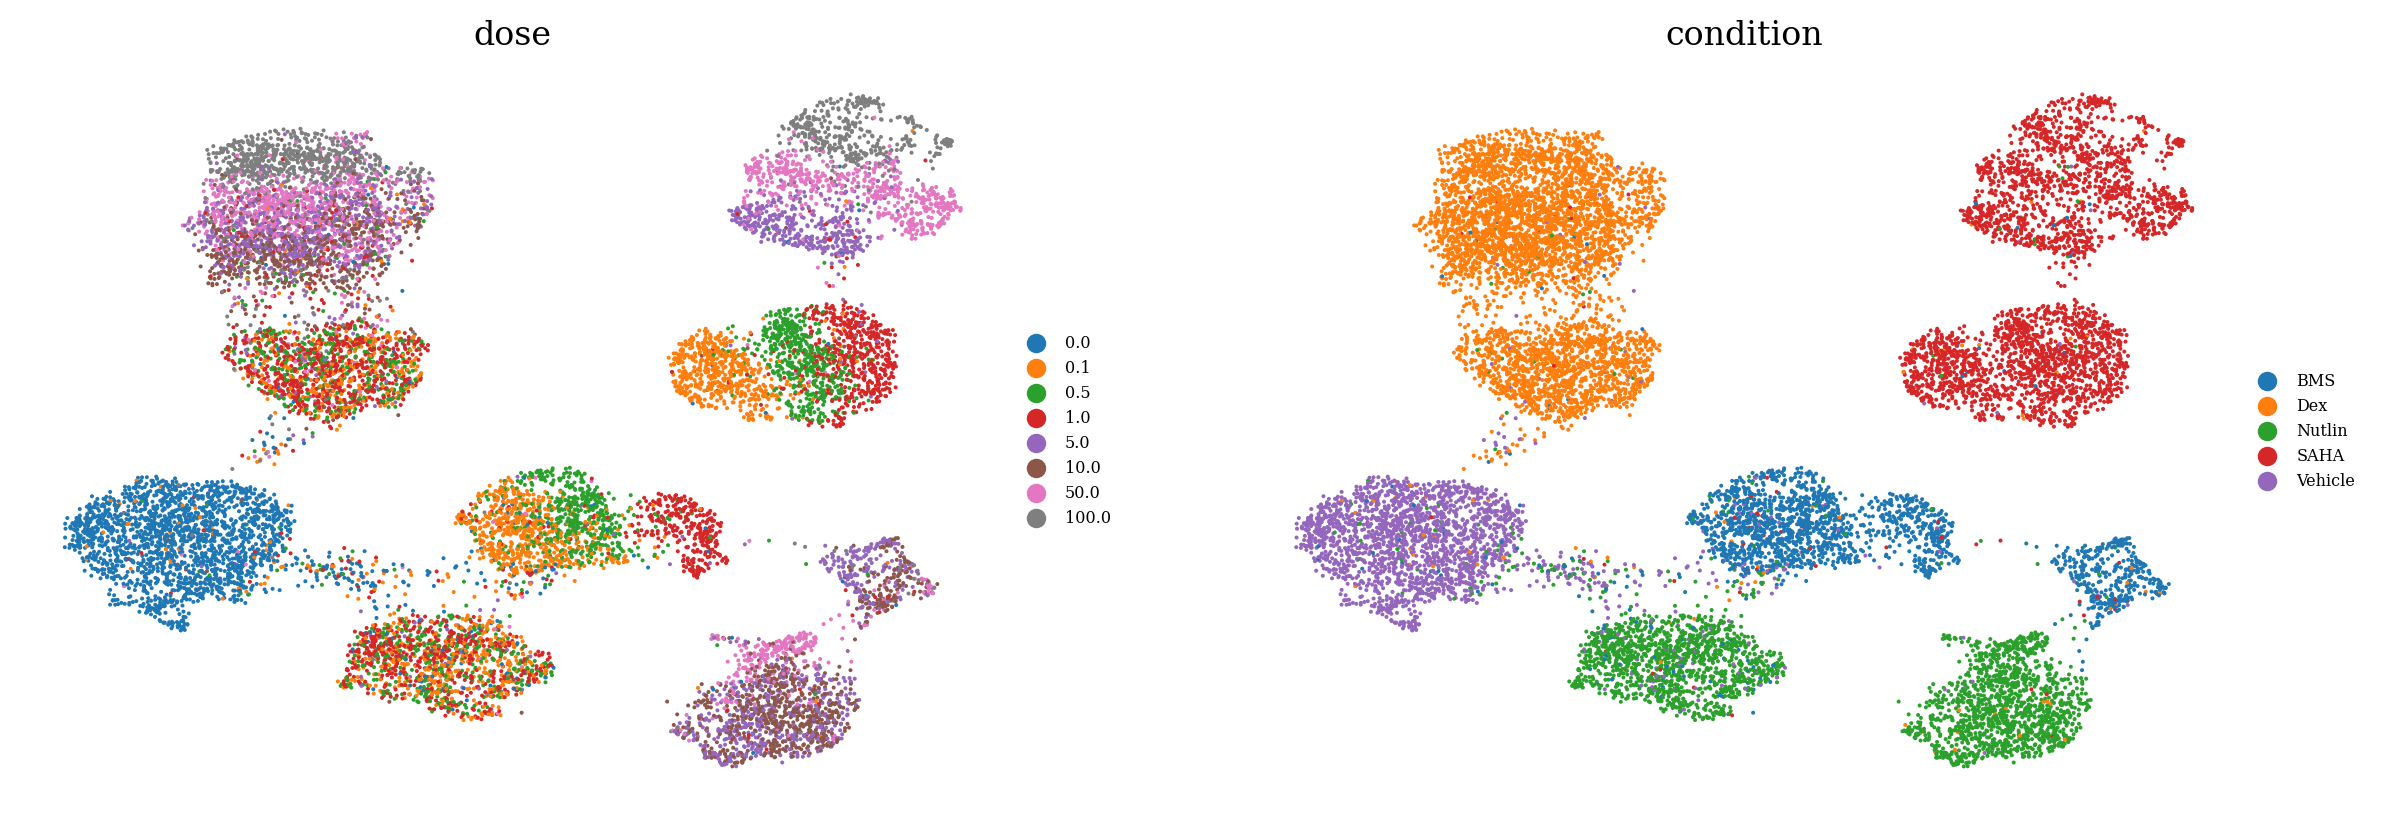

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

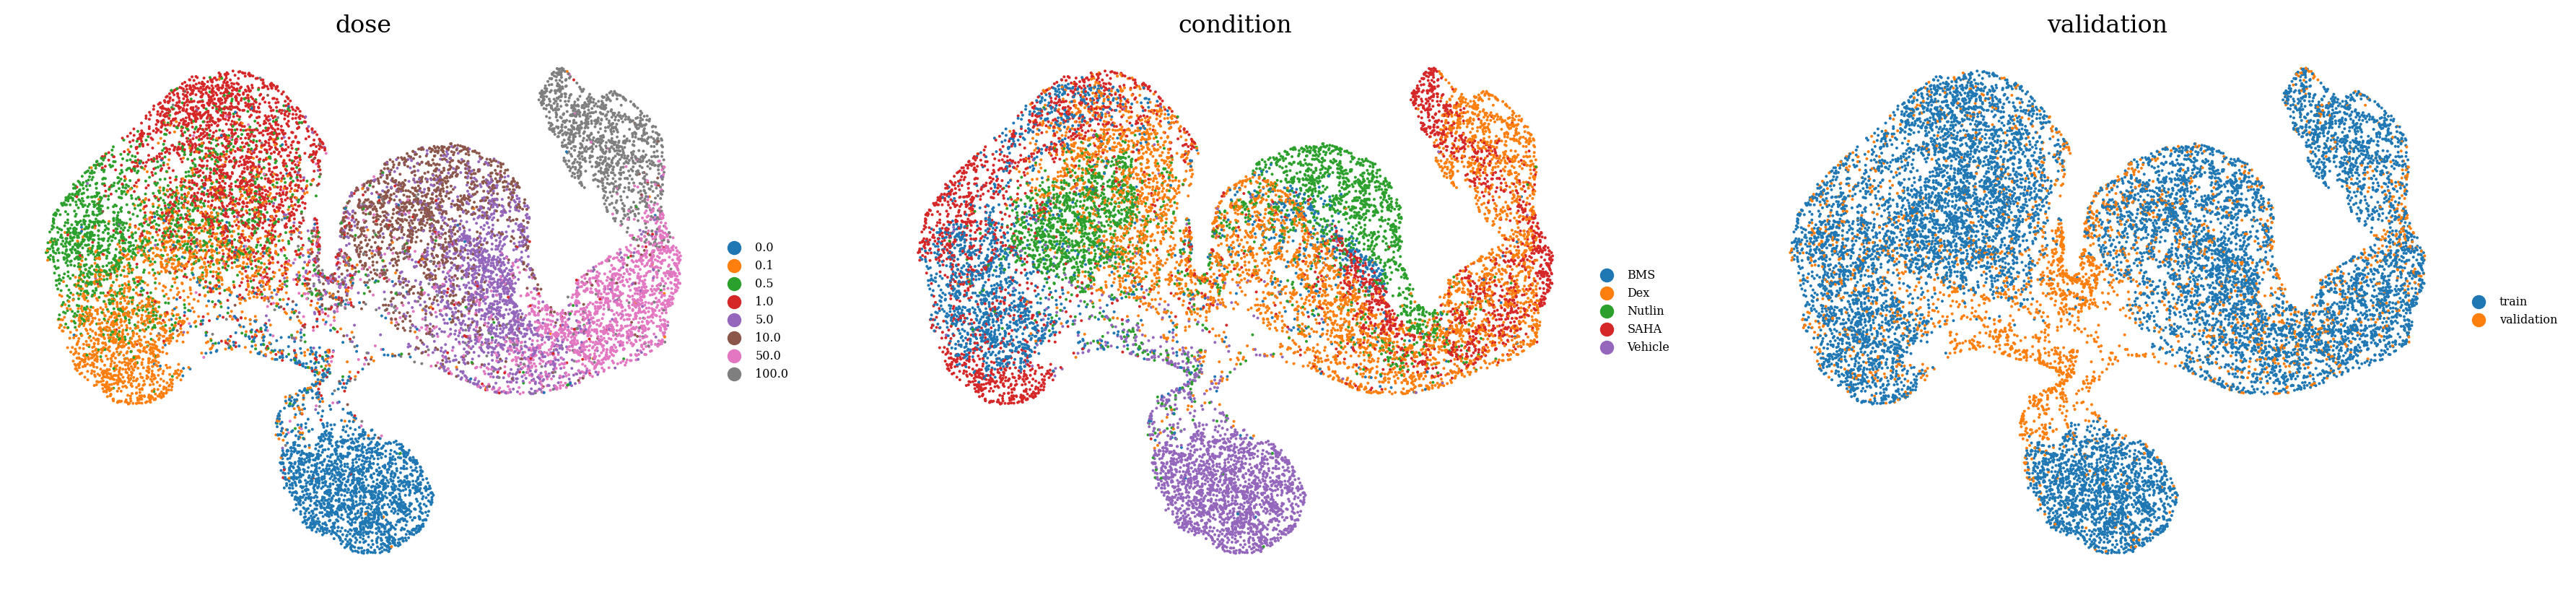

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

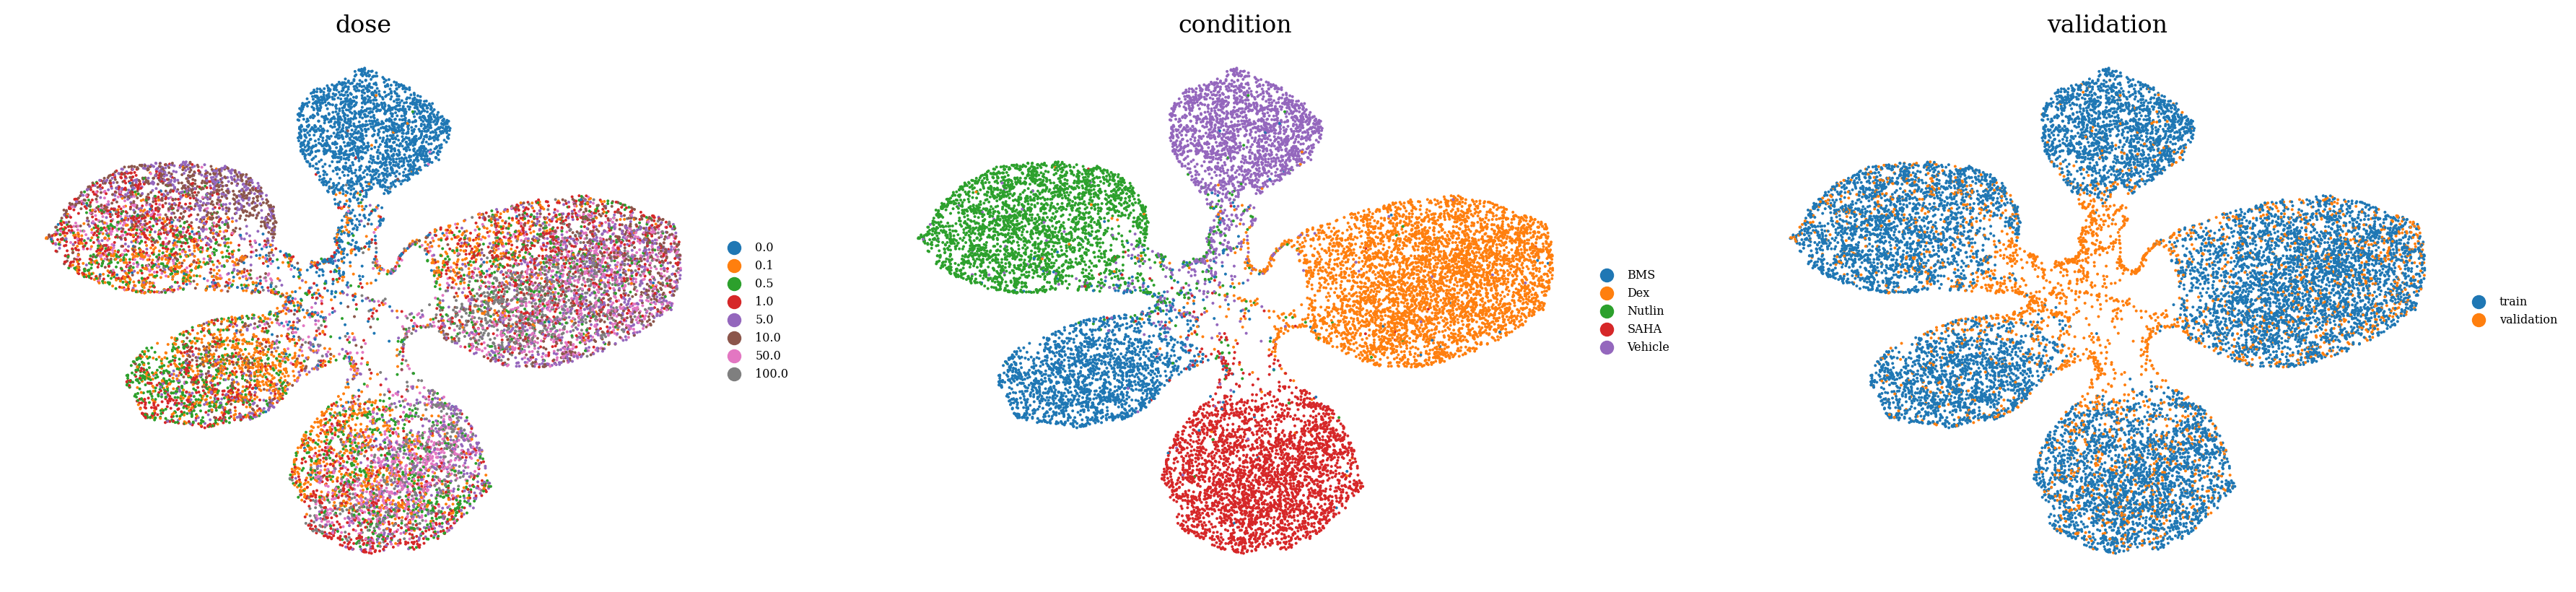

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [28]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [29]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


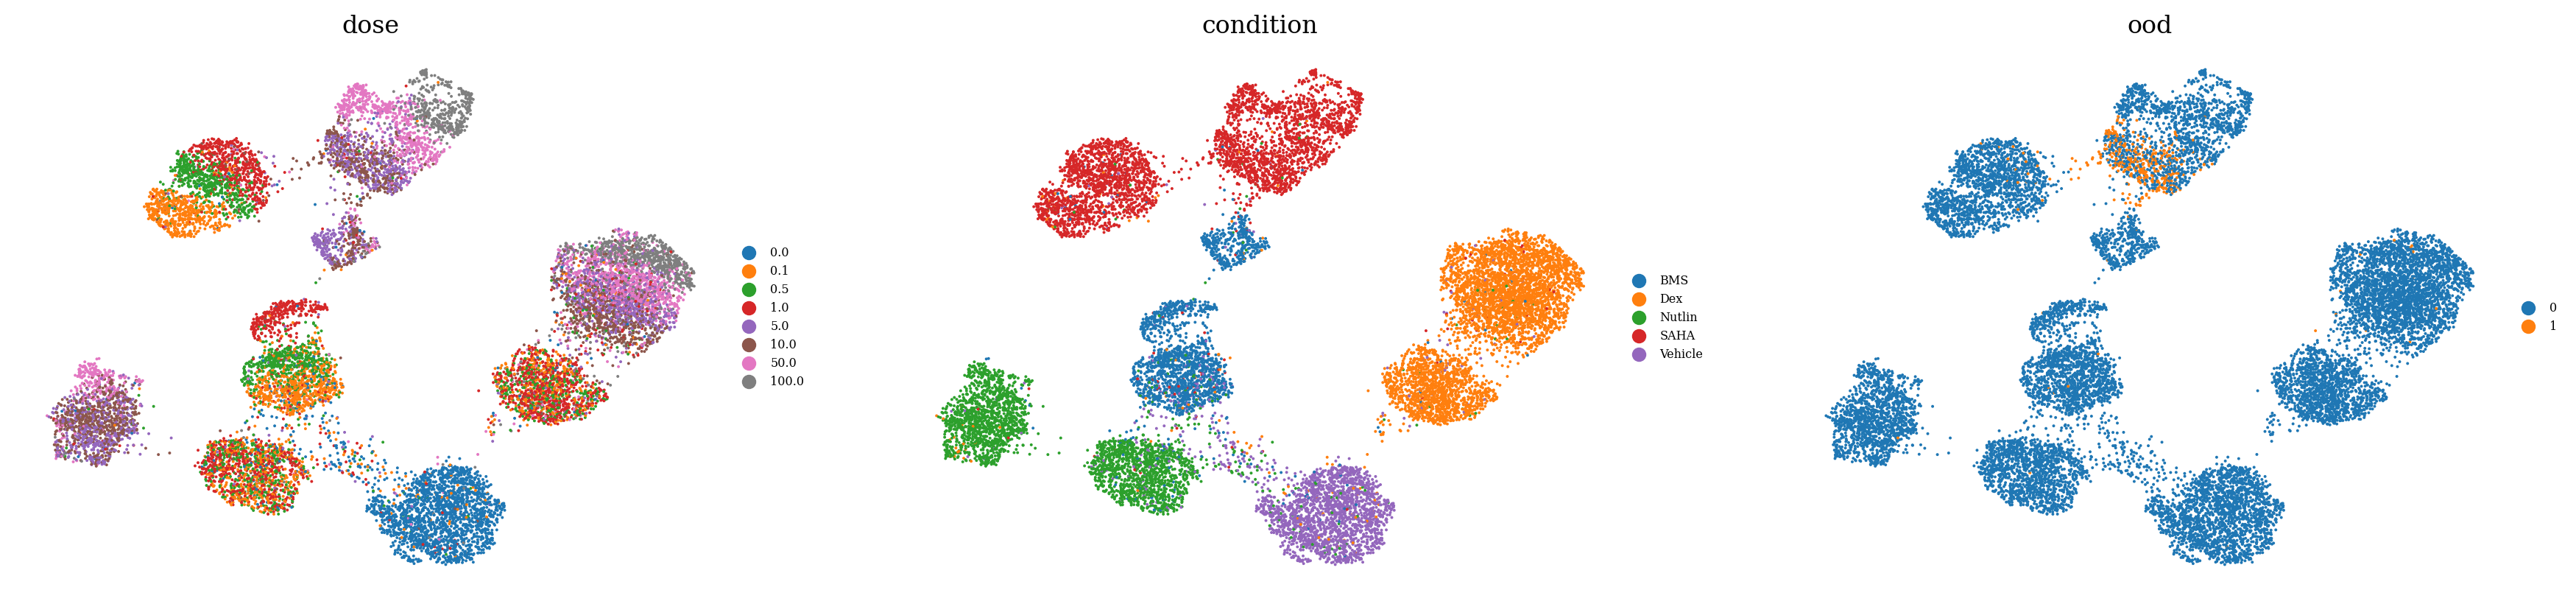

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
k = "dose_training"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


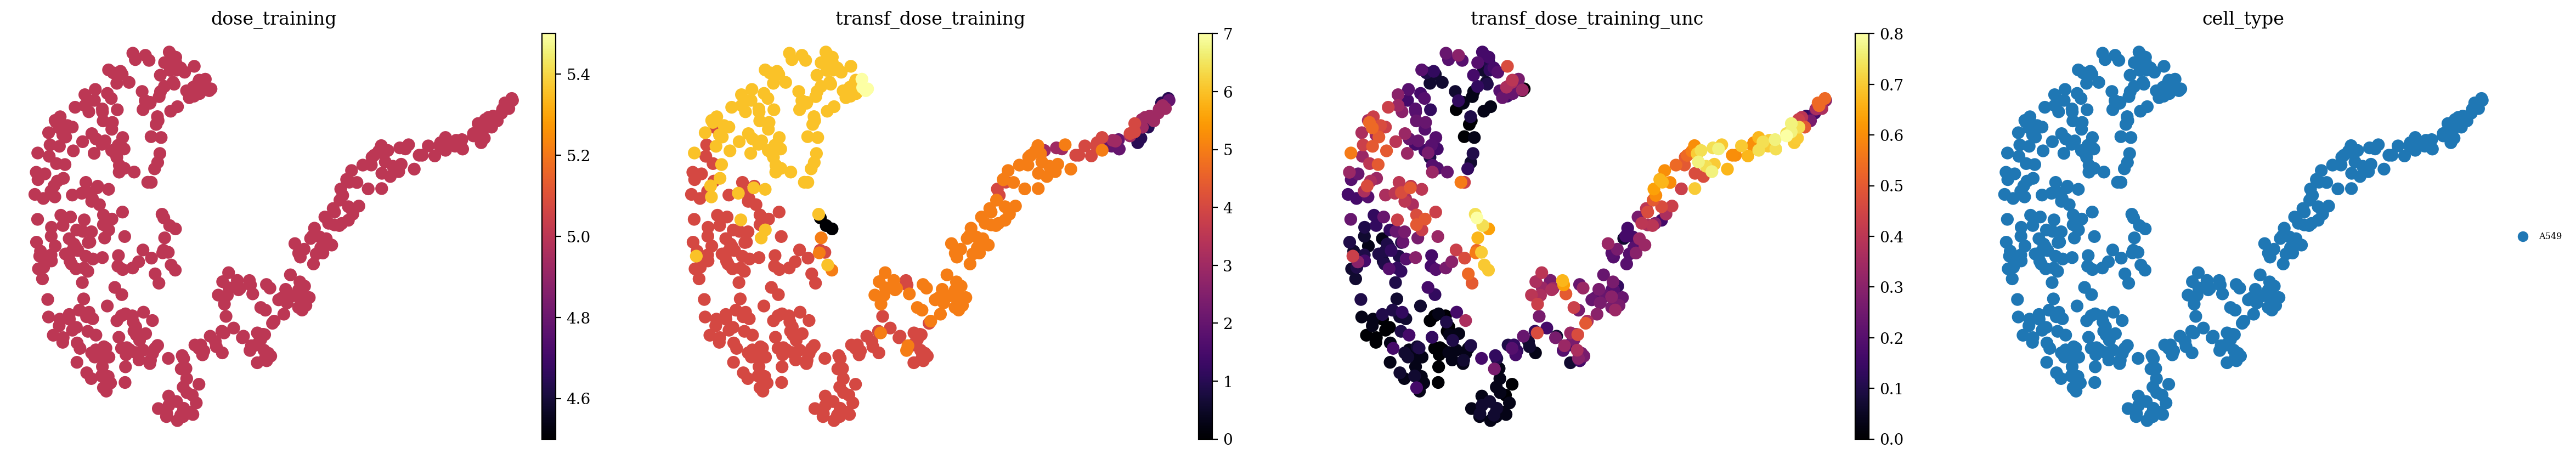

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [33]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.19953051643192488,
 'precision_macro': 0.125,
 'recall_macro': 0.02494131455399061,
 'f1_score_macro': 0.041585127201565555,
 'precision_micro': 0.19953051643192488,
 'recall_micro': 0.19953051643192488,
 'f1_score_micro': 0.1995305164319249,
 'precision_weighted': 1.0,
 'recall_weighted': 0.19953051643192488,
 'f1_score_weighted': 0.3326810176125244,
 'confusion_matrix': array([[  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  3,   6,   5,  15, 202,  85, 105,   5],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]])}

In [34]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.14658024441293632


In [35]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.12740530686651813
